In [1]:
# Cell 1: 라이브러리 및 설정
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.impute import SimpleImputer # 필요시 기본 결측치 처리 (이제 사용 안 함)
# from sklearn.ensemble import RandomForestRegressor # HB 결측치 처리용 (이제 사용 안 함)
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # 스케일러 저장용
import streamlit as st # GUI용 (Cell 12에서만 사용)
import os # GUI용 파일 경로 확인

# 데이터 경로 정의 (파일명 확인 및 수정)
data_path = "/Users/yeojoon/Documents/PyWorkspace_CreativeDesign/TrainSet0507_NoDuplicates.xlsx" #_NoDuplicates

# 장치 설정 (가능하면 GPU/MPS, 아니면 CPU 사용)
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
print(f"사용 장치: {device}")

# 재현성을 위한 랜덤 시드 설정
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
elif device == 'mps':
     pass

print("라이브러리 임포트 및 설정 완료.")

사용 장치: mps
라이브러리 임포트 및 설정 완료.


In [2]:
# Cell 2: 데이터 로딩 및 초기 검사

try:
    # 'Tensile' 시트 로드
    df_tensile = pd.read_excel(data_path, sheet_name='Tensile', header=0)
    print("--- Tensile 시트 ---")
    print(f"형태: {df_tensile.shape}")
    print("\n컬럼:", df_tensile.columns.tolist())
    print("\n처음 5행:\n", df_tensile.head())
    print("\n데이터 타입:\n", df_tensile.dtypes)
    print("\n결측치 요약:\n", df_tensile.isnull().sum())

except FileNotFoundError:
    print(f"오류: {data_path}에서 파일을 찾을 수 없습니다")
except Exception as e:
    print(f"데이터 로딩 중 오류 발생: {e}")

# 필요한 컬럼명 확인 (주석)
# E: 'E'
# YS: 'YS'
# TS: 'TS'
# HB: 'HB'
# HV: 'HV'
# sf: 'sf' (sigma_f')
# b: 'b'
# ef: 'ef' (epsilon_f')
# c: 'c'


# np_col = "n'" # 선택사항
# kp_col = "K' (MPa)" # 선택사항


--- Tensile 시트 ---
형태: (934, 19)

컬럼: ['Material', 'HeatTreatment', 'E', 'YS', 'TS', 'EL', 'RA', 'K', 'n', 'HV', 'HB', 'sy', 'np', 'Kp', 'sf', 'b', 'ef', 'c', '특이사항']

처음 5행:
   Material HeatTreatment      E   YS     TS    EL   RA      K      n  HV   HB  \
0   0.6040           NaN  140.0  420  570.0   NaN  NaN  902.0  0.130 NaN  NaN   
1   0.7040           NaN  165.0  323  470.0  17.3  NaN  514.0  0.076 NaN  NaN   
2   0.7060           NaN  158.0  382  632.0     7  NaN  507.0  0.043 NaN  NaN   
3   0.7060           NaN  175.0  480  738.0   4.4  NaN    NaN    NaN NaN  NaN   
4   0.8155           NaN  155.0  389  600.0     5  NaN  582.0  0.073 NaN  NaN   

   sy     np    Kp   sf      b      ef      c                    특이사항  
0 NaN  0.153  1012  646 -0.078  0.0353 -0.451                     NaN  
1 NaN  0.065   677  851 -0.075  9.7123 -1.016                     NaN  
2 NaN  0.076   750  720 -0.058  0.7236 -0.782  C 3.52 Si 2.69 Mn 0.53  
3 NaN  0.103   936  805 -0.067  0.2314 -0.652    

In [3]:
# Cell 3: 컬럼 이름 변경 및 타입 변환

# --- 컬럼 이름 매핑 정의 (실제 파일 컬럼명 기준) ---
column_mapping = {
    'E': 'E_GPa',
    'YS': 'YS_MPa',
    'TS': 'TS_MPa',
    'HB': 'HB',
    'HV': 'HV',
    "sf": 'spf_MPa',
    'b': 'b',
    "ef": 'epf',
    'c': 'c',
    # 사용할 경우 선택적 컬럼 추가
    # "n'": 'np',
    # "K' (MPa)": 'Kp_MPa',
    # 'Material Name', 'RA (%)' 등과 같은 다른 관련 컬럼 추가
    #'RA': 'RA_percent' # RA가 존재하고 필요한 경우 예시
}

# 사용할 컬럼만 선택 및 이름 변경
required_cols = list(column_mapping.keys())
available_cols = [col for col in required_cols if col in df_tensile.columns]
missing_cols = [col for col in required_cols if col not in available_cols]

print(f"\n사용 가능한 컬럼: {available_cols}")
if missing_cols:
    print(f"경고: 다음 컬럼이 데이터에 없습니다: {missing_cols}. 해당 컬럼 없이 진행합니다.")
    # 필수 컬럼 누락 시 에러 처리 또는 중지 로직 추가 가능

# 사용 가능한 컬럼만으로 매핑 재생성
column_mapping_available = {k: v for k, v in column_mapping.items() if k in available_cols}

df = df_tensile[available_cols].copy()
df.rename(columns=column_mapping_available, inplace=True)

hv_col_exists = 'HV' in df.columns

# 숫자형 변환 (오류는 NaN)
numeric_cols_base = ['E_GPa', 'YS_MPa', 'TS_MPa', 'HB', 'spf_MPa', 'b', 'epf', 'c']
numeric_cols = [col for col in numeric_cols_base if col in df.columns] # 존재하는 컬럼만 대상으로 함
if hv_col_exists:
    numeric_cols.append('HV')

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

print("\n이름 변경 및 숫자 변환 후 DataFrame:")
print(df.head())
print("\n데이터 타입:\n", df.dtypes)
print("\n강제 변환 후 결측치 요약:\n", df.isnull().sum())

# E 단위 변환 (GPa -> MPa)
if 'E_GPa' in df.columns:
    df['E_MPa'] = df['E_GPa'] * 1000
    df.drop(columns=['E_GPa'], inplace=True)
    print("\nE를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).")
    # Ensure E_MPa is in numeric_cols if E_GPa was
    if 'E_GPa' in numeric_cols:
        numeric_cols.remove('E_GPa')
        if 'E_MPa' not in numeric_cols:
             numeric_cols.append('E_MPa')


# 최종 특성 및 타겟 컬럼 이름 정의 (HB는 Cell 4에서 처리 후 추가)
feature_cols_base = ['E_MPa', 'YS_MPa', 'TS_MPa']
feature_cols = [col for col in feature_cols_base if col in df.columns] # 존재하는 특성만 사용
target_cols_base = ['spf_MPa', 'b', 'epf', 'c']
target_cols = [col for col in target_cols_base if col in df.columns] # 존재하는 타겟만 사용

# 타겟 변수 누락 행 제거
if not target_cols:
     print("오류: 타겟 변수가 하나도 없습니다. 학습을 진행할 수 없습니다.")
else:
    initial_rows = len(df)
    df.dropna(subset=target_cols, inplace=True)
    print(f"\n타겟 값({target_cols})이 누락된 {initial_rows - len(df)}개 행을 삭제했습니다.")
    print(f"남은 행: {len(df)}")


사용 가능한 컬럼: ['E', 'YS', 'TS', 'HB', 'HV', 'sf', 'b', 'ef', 'c']

이름 변경 및 숫자 변환 후 DataFrame:
   E_GPa  YS_MPa  TS_MPa  HB  HV  spf_MPa      b     epf      c
0  140.0   420.0   570.0 NaN NaN    646.0 -0.078  0.0353 -0.451
1  165.0   323.0   470.0 NaN NaN    851.0 -0.075  9.7123 -1.016
2  158.0   382.0   632.0 NaN NaN    720.0 -0.058  0.7236 -0.782
3  175.0   480.0   738.0 NaN NaN    805.0 -0.067  0.2314 -0.652
4  155.0   389.0   600.0 NaN NaN    712.0 -0.073  0.1460 -0.573

데이터 타입:
 E_GPa      float64
YS_MPa     float64
TS_MPa     float64
HB         float64
HV         float64
spf_MPa    float64
b          float64
epf        float64
c          float64
dtype: object

강제 변환 후 결측치 요약:
 E_GPa       17
YS_MPa      40
TS_MPa      29
HB         259
HV         889
spf_MPa     12
b            5
epf         13
c            9
dtype: int64

E를 MPa로 변환했습니다('E_MPa' 컬럼 생성됨).

타겟 값(['spf_MPa', 'b', 'epf', 'c'])이 누락된 16개 행을 삭제했습니다.
남은 행: 918


In [4]:
# Cell 4: HB/HV 처리 (수정됨 - ML/Median 대체 제거, HV 변환 우선)

hb_col_name = 'HB' # 원본 HB 컬럼명 (매핑 후 이름)
hv_col_name = 'HV' # 원본 HV 컬럼명 (매핑 후 이름)
hb_processed_col = 'HB_processed' # 새로 생성할 처리된 HB 컬럼

if hb_col_name not in df.columns:
    print(f"경고: HB 컬럼('{hb_col_name}')이 없습니다. HB 특성을 사용할 수 없습니다.")
    # HB 컬럼이 아예 없으면 hb_processed 생성 불가 -> 이후 로직에서 HB 사용 제외 필요
    hb_available = False
else:
    hb_available = True
    df[hb_processed_col] = df[hb_col_name].copy() # 기본값: 원본 HB 사용

    # HB가 NaN 이고 HV가 있는 경우, HV -> HB 변환
    if hv_col_exists:
        conversion_mask = df[hb_processed_col].isnull() & df[hv_col_name].notnull()
        # 예시 변환 (필요시 수정)
        df.loc[conversion_mask, hb_processed_col] = 0.95 * df.loc[conversion_mask, hv_col_name]
        print(f"Imputed {conversion_mask.sum()} missing HB values using HV conversion.")
    else:
        print("HV column not found. Skipping HV->HB conversion.")

    # HB_processed 컬럼을 feature_cols 에 추가
    feature_cols.append(hb_processed_col)
    print(f"\n'{hb_processed_col}' 컬럼을 특성에 추가했습니다.")

    # HB_processed 가 여전히 NaN 인 행은 HB/HV 모두 없는 경우 -> 분석에서 제외
    initial_rows_before_hb_drop = len(df)
    df.dropna(subset=[hb_processed_col], inplace=True)
    dropped_for_hb = initial_rows_before_hb_drop - len(df)
    if dropped_for_hb > 0:
        print(f"\nDropped {dropped_for_hb} rows where both HB and HV were missing or invalid.")


# 최종 특성 컬럼에서 결측치가 있는 행 제거 (E, YS, TS 등 포함)
initial_rows_before_feature_drop = len(df)
df.dropna(subset=feature_cols, inplace=True)
dropped_for_features = initial_rows_before_feature_drop - len(df)
if dropped_for_features > 0:
     print(f"Dropped {dropped_for_features} rows with missing values in features: {feature_cols}.")

print(f"\nFinal Feature Columns: {feature_cols}")
print(f"Target Columns: {target_cols}")
print("\nDataFrame after HB/HV processing and final NA drop:")
print(df[feature_cols + target_cols].head())
print("\nMissing values check for final features and targets:")
print(df[feature_cols + target_cols].isnull().sum())
print(f"Final number of samples for training/testing: {len(df)}")

Imputed 39 missing HB values using HV conversion.

'HB_processed' 컬럼을 특성에 추가했습니다.

Dropped 213 rows where both HB and HV were missing or invalid.
Dropped 23 rows with missing values in features: ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed'].

Final Feature Columns: ['E_MPa', 'YS_MPa', 'TS_MPa', 'HB_processed']
Target Columns: ['spf_MPa', 'b', 'epf', 'c']

DataFrame after HB/HV processing and final NA drop:
       E_MPa  YS_MPa  TS_MPa  HB_processed  spf_MPa      b     epf      c
28  206000.0   540.0   790.0       2280.00    987.0 -0.083  0.9672 -0.712
31  181000.0   149.0   411.0        168.15    575.0 -0.097  0.1141 -0.371
32  177000.0   147.0   413.0        190.00    517.0 -0.082  0.1273 -0.379
33  158000.0   130.0   389.0        208.05    479.0 -0.068  0.0817 -0.370
34  204000.0   222.0   569.0        227.05   1655.0 -0.134  0.0667 -0.322

Missing values check for final features and targets:
E_MPa           0
YS_MPa          0
TS_MPa          0
HB_processed    0
spf_MPa         0
b 


--- Exploratory Data Analysis ---

Descriptive Statistics (Features and Targets):
               E_MPa       YS_MPa       TS_MPa  HB_processed      spf_MPa  \
count     682.000000   682.000000   682.000000    682.000000   682.000000   
mean   204432.760997   738.860850   977.870352    272.623534  1447.090264   
std      9441.368531   442.427281   448.443995    136.786215   632.349316   
min    158000.000000   130.000000   318.000000     80.000000   391.000000   
25%    200000.000000   413.250000   666.000000    189.000000  1043.025000   
50%    206000.000000   622.000000   898.000000    252.000000  1255.000000   
75%    210000.000000   936.250000  1146.750000    324.275000  1694.000000   
max    249000.000000  2536.000000  2950.000000   2280.000000  5813.000000   

                b         epf           c  
count  682.000000  682.000000  682.000000  
mean    -0.094058    0.828002   -0.602977  
std      0.029741    1.450465    0.137286  
min     -0.253000    0.000570   -1.082000  
25%

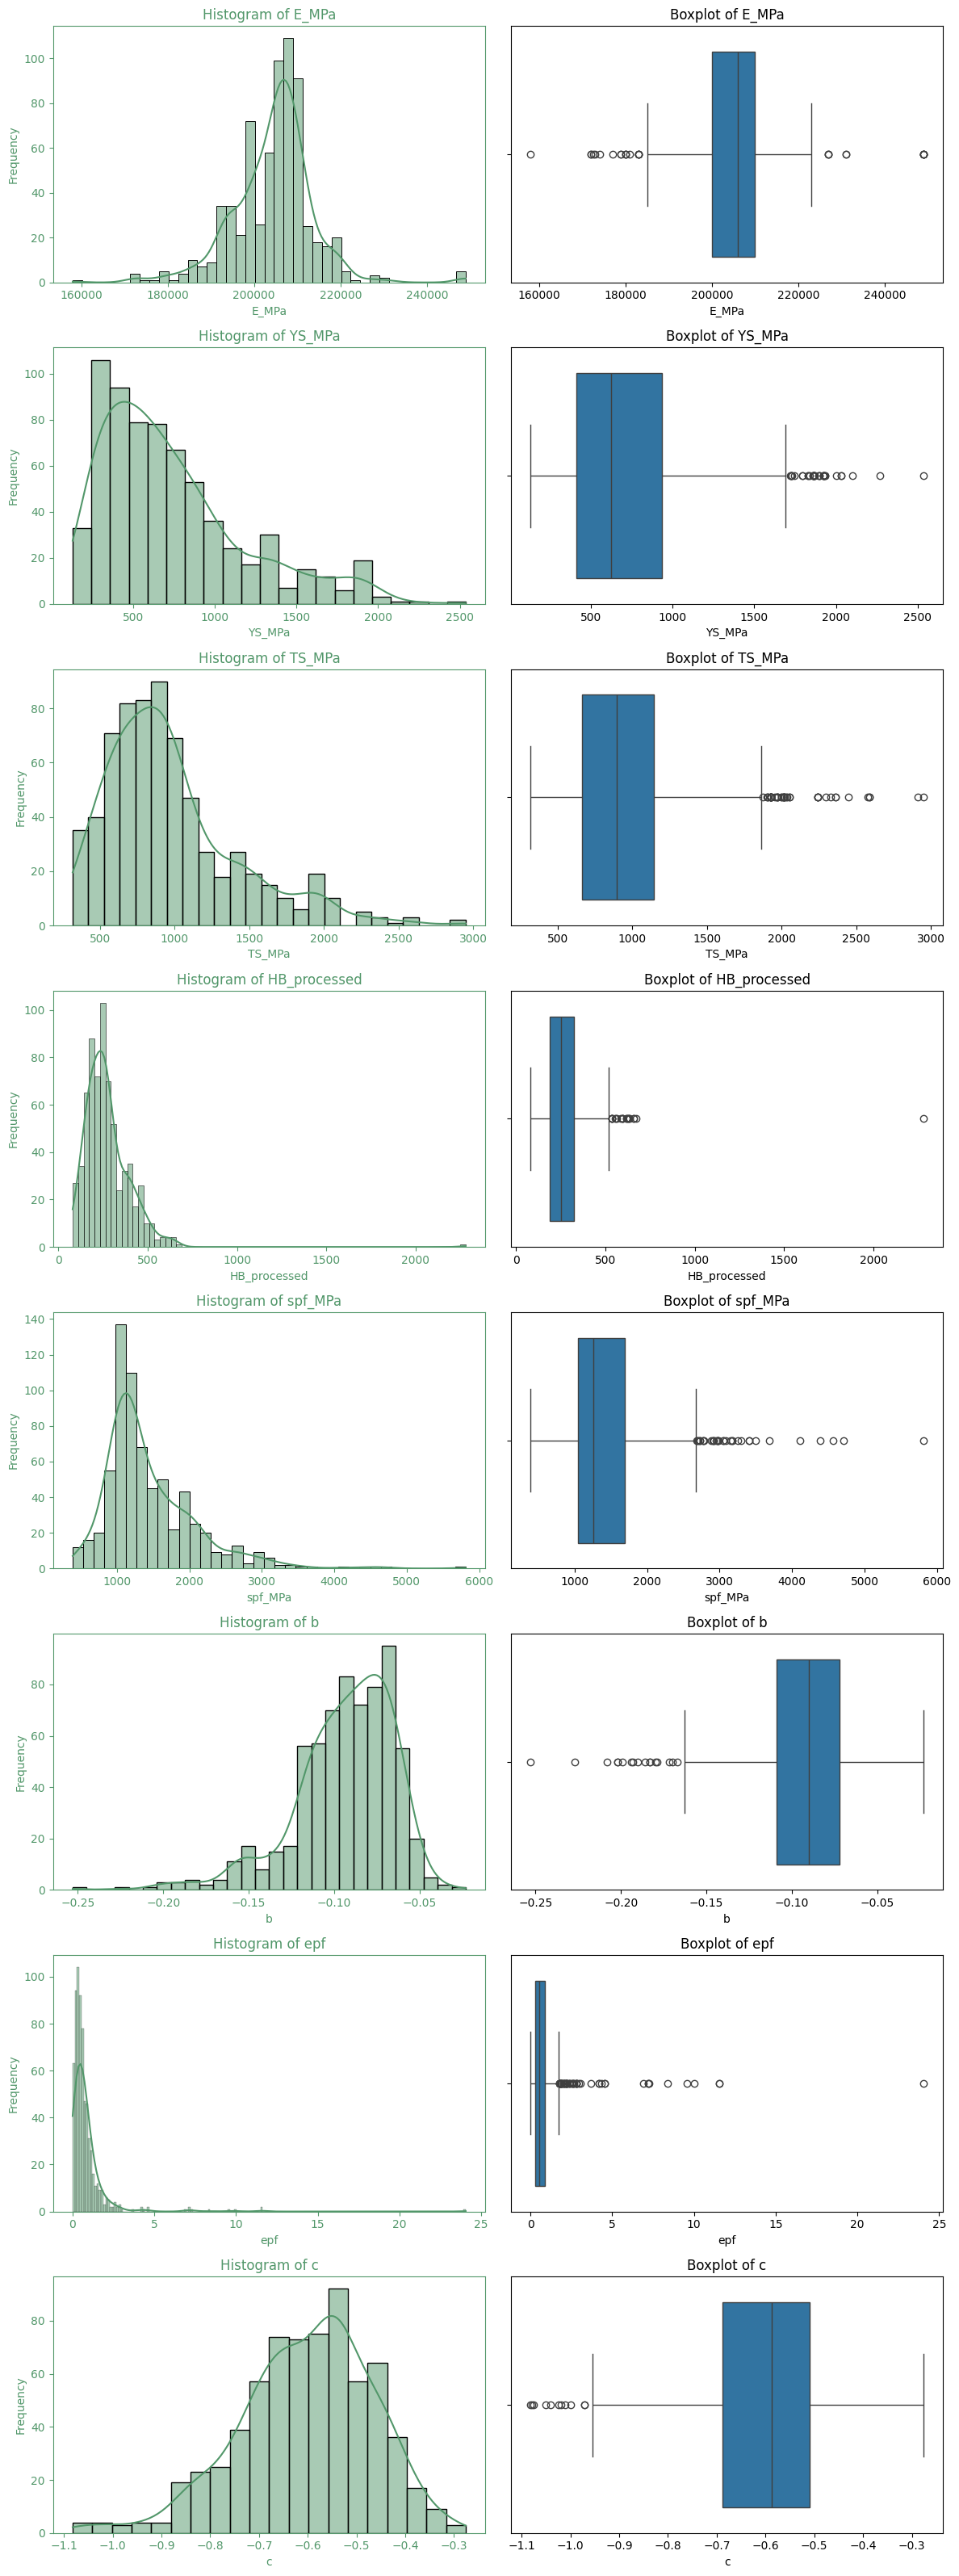

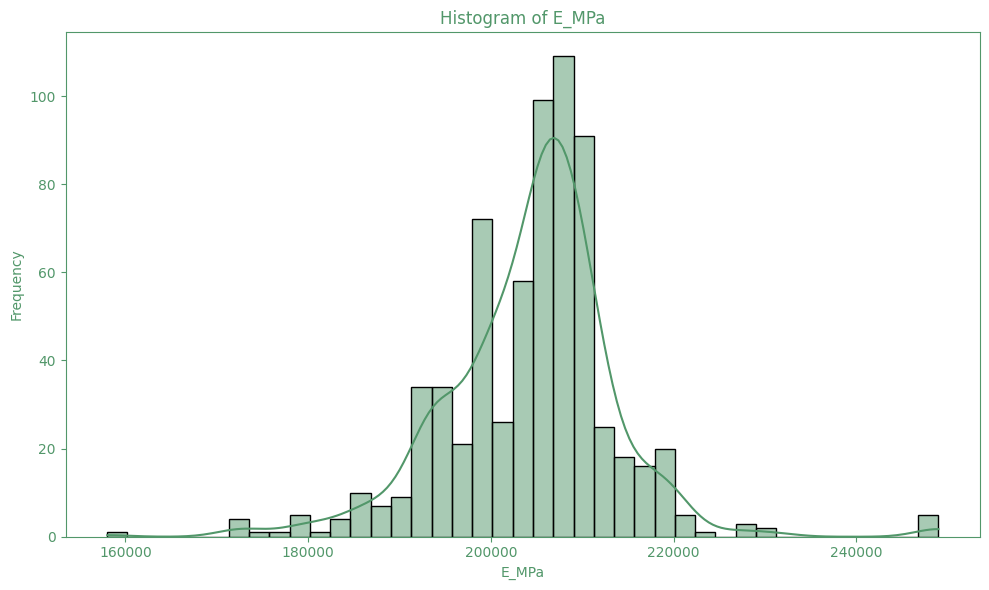


Calculating and Plotting Correlation Matrix...


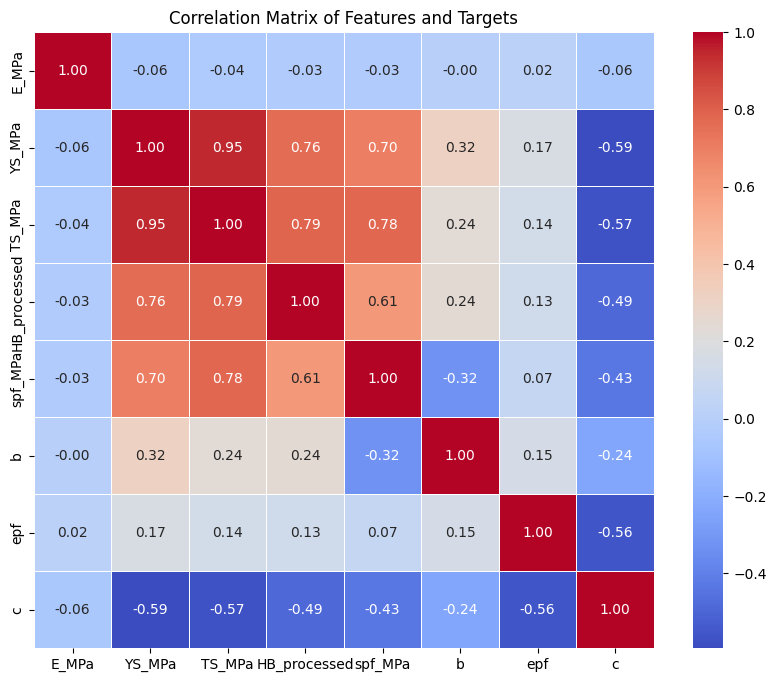


Analysis of target parameters:
Range of 'b': -0.253 -0.023
Range of 'c': -1.082 -0.276
Percentage of non-negative 'b': 0.00%
Percentage of non-negative 'c': 0.00%
Percentage where spf_MPa <= TS_MPa: 2.05%


In [5]:
# Cell 5: 탐색적 데이터 분석 (EDA) - 큰 변경 없음, HB_imputed_flag_col 관련 부분 제거

print("\n--- Exploratory Data Analysis ---")

if len(df) > 0: # 데이터가 남아있는 경우에만 EDA 수행
    # 1. Descriptive Statistics
    print("\nDescriptive Statistics (Features and Targets):")
    print(df[feature_cols + target_cols].describe())

    # 2. Distributions
    print("\nPlotting Distributions...")
    n_features = len(feature_cols)
    n_targets = len(target_cols)
    # figure 크기 동적 조절
    fig_height = max(4 * (n_features + n_targets), 12)
    fig, axes = plt.subplots(n_features + n_targets, 2, figsize=(12, fig_height), facecolor='none')

    if n_features + n_targets == 1: # 축 객체가 1차원 배열인 경우 처리
        axes = np.array([axes])
        
    # custom color 정의
    custom_color = (82/255, 151/255, 106/255)  # RGB 값

    for i, col in enumerate(feature_cols + target_cols):
        if col in df.columns: # 컬럼 존재 확인
             # 1열(히스토그램)에 custom color 적용
             sns.histplot(df[col], kde=True, ax=axes[i, 0], color=custom_color)
             axes[i, 0].set_title(f'Histogram of {col}', color=custom_color)
             axes[i, 0].set_xlabel(col, color=custom_color)
             axes[i, 0].set_ylabel('Frequency', color=custom_color)
             axes[i, 0].tick_params(axis='x', colors=custom_color)
             axes[i, 0].tick_params(axis='y', colors=custom_color)
             axes[i, 0].spines['bottom'].set_color(custom_color)
             axes[i, 0].spines['top'].set_color(custom_color)
             axes[i, 0].spines['left'].set_color(custom_color)
             axes[i, 0].spines['right'].set_color(custom_color)
             axes[i, 0].set_facecolor('none')  # 배경 투명하게 설정
             
             # 2열(박스플롯)은 기본 색상 유지
             sns.boxplot(x=df[col], ax=axes[i, 1])
             axes[i, 1].set_title(f'Boxplot of {col}')
             axes[i, 1].set_facecolor('none')  # 배경 투명하게 설정

    plt.tight_layout()
    plt.show()
    
    # custom color 그래프 추가 (첫 번째 컬럼만)
    if len(feature_cols) > 0:
        custom_color = (82/255, 151/255, 106/255)  # RGB 값
        first_col = feature_cols[0]
        
        fig, ax = plt.subplots(figsize=(10, 6), facecolor='none')  # 배경 투명하게 설정
        sns.histplot(df[first_col], kde=True, ax=ax, color=custom_color)
        
        # 모든 요소를 custom color로 설정
        ax.set_title(f'Histogram of {first_col}', color=custom_color)
        ax.set_xlabel(first_col, color=custom_color)
        ax.set_ylabel('Frequency', color=custom_color)
        ax.tick_params(axis='x', colors=custom_color)
        ax.tick_params(axis='y', colors=custom_color)
        ax.spines['bottom'].set_color(custom_color)
        ax.spines['top'].set_color(custom_color)
        ax.spines['left'].set_color(custom_color)
        ax.spines['right'].set_color(custom_color)
        ax.set_facecolor('none')  # 배경 투명하게 설정
        
        plt.tight_layout()
        plt.show()

    # 3. Correlation Matrix
    print("\nCalculating and Plotting Correlation Matrix...")
    # 상관관계 계산 전, 수치형 데이터만 있는지 확인
    numeric_df_for_corr = df[feature_cols + target_cols].select_dtypes(include=np.number)
    if not numeric_df_for_corr.empty:
        correlation_matrix = numeric_df_for_corr.corr()
        plt.figure(figsize=(10, 8), facecolor='none')  # 배경 투명하게 설정
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
        plt.title('Correlation Matrix of Features and Targets')
        plt.gca().set_facecolor('none')  # 히트맵 배경 투명하게 설정
        plt.show()
    else:
        print("No numeric columns found for correlation analysis.")


    # 4. Pair Plots (optional)
    # ...

    # 5. Analysis of Target Parameters (Physical Plausibility)
    print("\nAnalysis of target parameters:")
    if 'b' in df.columns: print("Range of 'b':", df['b'].min(), df['b'].max())
    if 'c' in df.columns: print("Range of 'c':", df['c'].min(), df['c'].max())
    if 'b' in df.columns: print(f"Percentage of non-negative 'b': { (df['b'] >= 0).mean() * 100:.2f}%")
    if 'c' in df.columns: print(f"Percentage of non-negative 'c': { (df['c'] >= 0).mean() * 100:.2f}%")
    if 'spf_MPa' in df.columns and 'TS_MPa' in df.columns:
         print(f"Percentage where spf_MPa <= TS_MPa: { (df['spf_MPa'] <= df['TS_MPa']).mean() * 100:.2f}%")

    # HB imputation status 비교 제거 (HB_imputed_flag_col 없음)

else:
    print("\nNo data available for EDA after preprocessing.")


In [6]:
# Cell 6: 데이터 준비 (PyTorch용) - HB_processed 추가

print("\n--- Preparing Data for PyTorch (Tensile Model) ---")

if len(df) > 0:
    # Select final features (X) and targets (y) for tensile model
    X = df[feature_cols].values
    y = df[target_cols].values
    
    # E_MPa, TS_MPa, HB_processed 추출 (손실 함수용 비스케일링 값)
    E_for_loss = df['E_MPa'].values if 'E_MPa' in df.columns else np.zeros(len(df))
    TS_for_loss = df['TS_MPa'].values if 'TS_MPa' in df.columns else np.zeros(len(df))
    HB_for_loss = df['HB_processed'].values if 'HB_processed' in df.columns else np.zeros(len(df))
    
    print(f"Features shape (X): {X.shape}")
    print(f"Targets shape (y): {y.shape}")
    print(f"E for loss shape: {E_for_loss.shape}")
    print(f"TS for loss shape: {TS_for_loss.shape}")
    print(f"HB for loss shape: {HB_for_loss.shape}")

    # 1. Train-Validation-Test Split
    X_train_val, X_test, y_train_val, y_test, E_train_val, E_test, TS_train_val, TS_test, HB_train_val, HB_test = train_test_split(
        X, y, E_for_loss, TS_for_loss, HB_for_loss, test_size=0.15, random_state=seed)
    X_train, X_val, y_train, y_val, E_train, E_val, TS_train, TS_val, HB_train, HB_val = train_test_split(
        X_train_val, y_train_val, E_train_val, TS_train_val, HB_train_val, test_size=0.1765, random_state=seed) # 0.1765 * 0.85 ≈ 0.15

    print(f"Train set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    # 2. Scaling
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train)
    y_val_scaled = scaler_y.transform(y_val)
    y_test_scaled = scaler_y.transform(y_test)

    joblib.dump(scaler_X, 'scaler_X.pkl')
    joblib.dump(scaler_y, 'scaler_y.pkl')
    print("Features and targets scaled. Scalers saved.")

    # 3. Create PyTorch Datasets and DataLoaders
    batch_size = 16

    # 텐서 변환 (E, TS, HB 비스케일링 텐서 추가)
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    E_train_tensor = torch.tensor(E_train, dtype=torch.float32).unsqueeze(1)
    TS_train_tensor = torch.tensor(TS_train, dtype=torch.float32).unsqueeze(1)
    HB_train_tensor = torch.tensor(HB_train, dtype=torch.float32).unsqueeze(1)

    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)
    E_val_tensor = torch.tensor(E_val, dtype=torch.float32).unsqueeze(1)
    TS_val_tensor = torch.tensor(TS_val, dtype=torch.float32).unsqueeze(1)
    HB_val_tensor = torch.tensor(HB_val, dtype=torch.float32).unsqueeze(1)

    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)
    E_test_tensor = torch.tensor(E_test, dtype=torch.float32).unsqueeze(1)
    TS_test_tensor = torch.tensor(TS_test, dtype=torch.float32).unsqueeze(1)
    HB_test_tensor = torch.tensor(HB_test, dtype=torch.float32).unsqueeze(1)
    y_test_orig_tensor = torch.tensor(y_test, dtype=torch.float32)

    # TensorDataset 생성 (E, TS, HB 텐서 추가)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor, E_train_tensor, TS_train_tensor, HB_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor, E_val_tensor, TS_val_tensor, HB_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor, E_test_tensor, TS_test_tensor, HB_test_tensor, y_test_orig_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print("PyTorch Datasets and DataLoaders created (비스케일링 E, TS, HB 포함).")
    print(f"Number of training batches: {len(train_loader)}")
    print(f"Number of validation batches: {len(val_loader)}")
    print(f"Number of test batches: {len(test_loader)}")

else:
    print("\nNo data available for PyTorch preparation.")


--- Preparing Data for PyTorch (Tensile Model) ---
Features shape (X): (682, 4)
Targets shape (y): (682, 4)
E for loss shape: (682,)
TS for loss shape: (682,)
HB for loss shape: (682,)
Train set size: 476
Validation set size: 103
Test set size: 103
Features and targets scaled. Scalers saved.
PyTorch Datasets and DataLoaders created (비스케일링 E, TS, HB 포함).
Number of training batches: 30
Number of validation batches: 7
Number of test batches: 7


In [7]:
# Cell 7: PINN 모델 정의 (FatiguePINN) - 구조 [128, 256, 128], dropout 0.2 적용

if len(df) > 0:
    class FatiguePINN(nn.Module):
        def __init__(self, input_dim, output_dim, hidden_dims=[128, 256, 128], dropout_p=0.2): # dropout_p 인자 유지
            super().__init__()
            self.input_dim = input_dim
            self.output_dim = output_dim
            self.dropout_p = dropout_p # 드롭아웃 비율 저장

            layers = []
            last_dim = input_dim
            for i, hidden_dim in enumerate(hidden_dims):
                layers.append(nn.Linear(last_dim, hidden_dim))
                layers.append(nn.ReLU())
                # --- 드롭아웃 레이어 추가 (이전과 동일) ---
                if self.dropout_p > 0:
                    layers.append(nn.Dropout(p=self.dropout_p))
                last_dim = hidden_dim
            
            layers.append(nn.Linear(last_dim, output_dim)) # 최종 출력 레이어
            self.network = nn.Sequential(*layers)

        def forward(self, x):
            return self.network(x)

    # 모델 인스턴스화
    input_dim = X_train_scaled.shape[1] if 'X_train_scaled' in locals() else 4
    output_dim = y_train_scaled.shape[1] if 'y_train_scaled' in locals() else 4
    
    # --- 여기를 수정합니다 (은닉층 구조 변경) ---
    hidden_dims_target = [128, 256, 128] # 목표하는 은닉층 구조 (3개 층)
    dropout_rate = 0.2                   # 드롭아웃 비율 설정
    
    # 모델 생성 시 수정된 hidden_dims와 dropout_p 전달
    model = FatiguePINN(input_dim, output_dim, 
                        hidden_dims=hidden_dims_target, 
                        dropout_p=dropout_rate).to(device)

    print(f"PINN Model Definition (FatiguePINN with hidden_dims={hidden_dims_target}, dropout_p={dropout_rate}):")
    print(model) # 변경된 모델 구조 확인

    # 더미 테스트
    try:
        batch_size_local = batch_size if 'batch_size' in locals() else 16
        dummy_input = torch.randn(batch_size_local, input_dim).to(device)
        dummy_output = model(dummy_input)
        print(f"\nDummy input shape: {dummy_input.shape}")
        print(f"Dummy output shape: {dummy_output.shape}")
    except Exception as e:
        print(f"\nCould not perform dummy test: {e}")
else:
    print("\nSkipping model definition as no data is available.")

PINN Model Definition (FatiguePINN with hidden_dims=[128, 256, 128], dropout_p=0.2):
FatiguePINN(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=4, bias=True)
  )
)

Dummy input shape: torch.Size([16, 4])
Dummy output shape: torch.Size([16, 4])


In [8]:
# Cell 7.5: 경험적 피로 매개변수 추정 방법 정의

def modified_universal_slopes(TS_MPa, E_MPa, epsilon_f=None):
    """
    추후 RA 값 확보 시 사용 가능.
    modified Universal Slopes 방법을 사용하여 spf와 epf를 계산.
    
    인자:
        TS_MPa (float): 인장 강도 (MPa)
        E_MPa (float): 탄성 계수 (MPa)
        epsilon_f (float, optional): 진 파단 변형률. 기본값은 None.
    반환:
        tuple: (spf_mus, epf_mus) 또는 epsilon_f가 None이면 (spf_mus, None)
    """
    spf_mus = 1.5 * TS_MPa
    epf_mus = None
    if epsilon_f is not None and E_MPa > 0 and TS_MPa > 0:
        # 거듭제곱 및 나눗셈을 위한 안전한 계산 보장
        term1 = max(epsilon_f, 1e-9) ** 0.155
        term2 = max(TS_MPa / E_MPa, 1e-9) ** -0.53
        epf_mus = 0.019 * term1 * term2
    elif epsilon_f is None:
        print("경고 (MUS): epsilon_f가 제공되지 않아 epf'를 계산할 수 없습니다.")
    else:
        print("경고 (MUS): epf' 계산을 위한 유효하지 않은 E_MPa 또는 TS_MPa.")
        
    return spf_mus, epf_mus

def uniform_material_law(TS_MPa, E_MPa):
    """
    Uniform Material Law를 사용하여 spf'와 epf'를 계산합니다.
    인자:
        TS_MPa (float): 인장 강도 (MPa)
        E_MPa (float): 탄성 계수 (MPa)
    반환:
        tuple: (spf_uml, epf_uml)
    """
    spf_uml = 1.5 * TS_MPa
    
    psi = 1.0
    ts_e_ratio = TS_MPa / E_MPa if E_MPa > 0 else 0
    
    if ts_e_ratio > 0.003:
        psi = 1.375 - 125 * ts_e_ratio
        # psi가 비물리적(예: 음수)이 되지 않도록 함
        psi = max(psi, 0.1) # 필요한 경우 최소 하한값 설정

    epf_uml = 0.59 * psi
    return spf_uml, epf_uml

def hardness_method(HB, E_MPa):
    """
    경도 방법(Roessle-Fatemi)을 사용하여 spf와 epf를 계산합니다.
    인자:
        HB (float): 브리넬 경도
        E_MPa (float): 탄성 계수 (MPa)
    반환:
        tuple: (spf_hard, epf_hard)
    """
    spf_hard = 4.25 * HB + 225
    
    epf_hard = None
    if E_MPa > 0:
        numerator = 0.32 * (HB**2) - 487 * HB + 191000
        epf_hard = numerator / E_MPa
        # epf가 비물리적(예: 음수)이 되지 않도록 함
        epf_hard = max(epf_hard, 1e-6) # 작은 양수 하한값 설정
    else:
         print("경고 (Hardness): epf' 계산을 위한 유효하지 않은 E_MPa.")
         
    return spf_hard, epf_hard

# HB 분류 경계(쉽게 수정 가능)
HB_CLASS1_MAX = 150
HB_CLASS2_MAX = 500
HB_CLASS3_MAX = 700

# 클래스별 방법 매핑(현재 모두 Hardness)
# 향후 ML 분류 통합을 위해 쉽게 수정 가능하도록 함
method_map = {
    1: hardness_method,  # 클래스 1: HB <= 150
    2: hardness_method,  # 클래스 2: 150 < HB <= 500
    3: hardness_method,  # 클래스 3: 500 < HB <= 700
    4: hardness_method   # 클래스 4: HB > 700
}

method_names = { # 로깅/표시용
    1: "Hardness Method",
    2: "Hardness Method",
    3: "Hardness Method",
    4: "Hardness Method"
}


def get_physics_params(hb_val, ts_mpa_val, e_mpa_val):
    """
    HB를 분류하고 매핑된 방법을 사용하여 물리 기반 spf와 epf를 반환합니다.
    """
    if hb_val <= HB_CLASS1_MAX:
        method_func = method_map[1]
        method_name = method_names[1]
    elif hb_val <= HB_CLASS2_MAX:
        method_func = method_map[2]
        method_name = method_names[2]
    elif hb_val <= HB_CLASS3_MAX:
        method_func = method_map[3]
        method_name = method_names[3]
    else:
        method_func = method_map[4]
        method_name = method_names[4]

    # 선택된 방법 함수 호출
    # 참고: 현재는 Hardness Method만 HB와 E를 사용합니다.
    #       UML은 TS와 E를 사용합니다. MUS는 epsilon_f가 필요합니다.
    #       방법이 변경되면 함수 호출을 조정하세요.
    if method_func == hardness_method:
         spf_physics, epf_physics = method_func(hb_val, e_mpa_val)
    elif method_func == uniform_material_law:
         spf_physics, epf_physics = method_func(ts_mpa_val, e_mpa_val)
    elif method_func == modified_universal_slopes:
         # MUS를 사용하는 경우 epsilon_f 소스 필요
         spf_physics, epf_physics = method_func(ts_mpa_val, e_mpa_val, epsilon_f=None) 
    else:
        spf_physics, epf_physics = None, None # 방법을 알 수 없는 경우 기본값
        method_name = "Unknown"

    return spf_physics, epf_physics, method_name

print("경험적 피로 매개변수 추정 방법이 정의되었습니다.")


경험적 피로 매개변수 추정 방법이 정의되었습니다.


In [9]:
# Cell 8: 손실 함수 정의 (PINN) - 하이브리드 손실 함수로 수정

if len(df) > 0:
    def pinn_hybrid_loss(model_outputs_scaled, targets_scaled, E_unscaled, TS_unscaled, HB_unscaled, scaler_y, lambda_physics=0.1, device='cpu'):
        """
        b, c에 대한 데이터 손실과 spf, epf에 대한 물리 손실을 계산하는 하이브리드 손실 함수입니다.

        Args:
            model_outputs_scaled (torch.Tensor): 스케일링된 NN 예측값 [spf', b', epf', c']. 형태: (batch_size, 4)
            targets_scaled (torch.Tensor): 스케일링된 타겟 파라미터 [spf, b, epf, c]. 형태: (batch_size, 4)
            E_unscaled (torch.Tensor): 탄성 계수 (MPa). 형태: (batch_size, 1)
            TS_unscaled (torch.Tensor): 인장 강도 (MPa). 형태: (batch_size, 1)
            HB_unscaled (torch.Tensor): 브리넬 경도 (처리됨). 형태: (batch_size, 1)
            scaler_y (StandardScaler): 타겟 파라미터용 피팅된 스케일러.
            lambda_physics (float): 물리 손실 구성 요소의 가중치 계수 (spf, epf).
            device (str): 장치 ('cpu', 'cuda', 'mps')

        Returns:
            tuple: (total_loss, data_loss_bc, physics_loss_spf_epf)
        """
        batch_size_current = model_outputs_scaled.shape[0]
        
        # --- 데이터 손실 (b, c만) ---
        data_loss_fn = nn.MSELoss()
        # 예측된 스케일링된 b, c 선택 (인덱스 1과 3)
        b_pred_scaled = model_outputs_scaled[:, 1]
        c_pred_scaled = model_outputs_scaled[:, 3]
        b_true_scaled = targets_scaled[:, 1]
        c_true_scaled = targets_scaled[:, 3]
        
        data_loss_b = data_loss_fn(b_pred_scaled, b_true_scaled)
        data_loss_c = data_loss_fn(c_pred_scaled, c_true_scaled)
        data_loss_bc = data_loss_b + data_loss_c # b와 c의 MSE 결합

        # --- 물리 손실 (spf, epf만) ---
        physics_loss_spf = torch.tensor(0.0, device=device)
        physics_loss_epf = torch.tensor(0.0, device=device)
        
        try:
            # 예측된 spf, epf를 원래 스케일로 역변환
            # 스케일러에는 모든 4개 출력이 필요하지만, spf, epf만 사용
            model_outputs_unscaled_np = scaler_y.inverse_transform(model_outputs_scaled.detach().cpu().numpy())
            model_outputs_unscaled = torch.tensor(model_outputs_unscaled_np, dtype=torch.float32).to(device)
            spf_pred_unscaled = model_outputs_unscaled[:, 0] # 형태: (batch_size,)
            epf_pred_unscaled = model_outputs_unscaled[:, 2] # 형태: (batch_size,)

            # 배치의 각 샘플에 대한 물리 기반 spf 및 epf 계산
            spf_physics_list = []
            epf_physics_list = []
            for i in range(batch_size_current):
                hb_val = HB_unscaled[i].item()
                ts_val = TS_unscaled[i].item()
                e_val = E_unscaled[i].item()
                
                # Cell 7.5에서 정의된 함수 사용
                spf_p, epf_p, _ = get_physics_params(hb_val, ts_val, e_val) 
                
                # 물리 계산이 실패할 수 있는 경우 처리 (None 반환)
                spf_physics_list.append(spf_p if spf_p is not None else torch.nan) 
                epf_physics_list.append(epf_p if epf_p is not None else torch.nan)

            spf_physics_targets = torch.tensor(spf_physics_list, dtype=torch.float32).to(device) # 형태: (batch_size,)
            epf_physics_targets = torch.tensor(epf_physics_list, dtype=torch.float32).to(device) # 형태: (batch_size,)

            # 유효한 물리 타겟에 대해서만 MSE 계산 (NaN 무시)
            valid_spf_mask = ~torch.isnan(spf_physics_targets)
            valid_epf_mask = ~torch.isnan(epf_physics_targets)

            if valid_spf_mask.any():
                 physics_loss_spf = data_loss_fn(spf_pred_unscaled[valid_spf_mask], spf_physics_targets[valid_spf_mask])
            if valid_epf_mask.any():
                 physics_loss_epf = data_loss_fn(epf_pred_unscaled[valid_epf_mask], epf_physics_targets[valid_epf_mask])
                 
            physics_loss_spf_epf = physics_loss_spf + physics_loss_epf

            # 최종 물리 손실에서 잠재적 NaN 처리
            if torch.isnan(physics_loss_spf_epf):
                 physics_loss_spf_epf = torch.tensor(0.0, device=device)
                 
        except Exception as e:
            print(f"경고: spf/epf에 대한 물리 손실 계산 중 오류 발생: {e}. 물리 손실을 0으로 설정합니다.")
            physics_loss_spf_epf = torch.tensor(0.0, device=device)

        # --- 총 손실 ---
        # 물리 기반 손실 구성 요소에만 lambda_physics 적용
        total_loss = data_loss_bc + lambda_physics * physics_loss_spf_epf

        return total_loss, data_loss_bc, physics_loss_spf_epf

    # --- 손실 함수 테스트 ---
    try:
        # 샘플 배치 가져오기 (이제 TS와 HB 포함)
        sample_X, sample_y_scaled, sample_E, sample_TS, sample_HB = next(iter(train_loader))
        sample_X = sample_X.to(device)
        sample_y_scaled = sample_y_scaled.to(device)
        sample_E = sample_E.to(device)
        sample_TS = sample_TS.to(device)
        sample_HB = sample_HB.to(device)

        model.eval()
        with torch.no_grad():
             sample_output_scaled = model(sample_X)

        # 원하는 lambda_physics 값 설정
        lambda_physics_value = 0.1 
        
        total_loss, data_loss_bc, physics_loss_spf_epf = pinn_hybrid_loss(
            sample_output_scaled, sample_y_scaled, sample_E, sample_TS, sample_HB, 
            scaler_y, lambda_physics=lambda_physics_value, device=device
        )

        print(f"\n하이브리드 손실 함수 테스트 (lambda_physics = {lambda_physics_value}):")
        print(f"  샘플 출력 (스케일링됨) 형태: {sample_output_scaled.shape}")
        print(f"  샘플 타겟 (스케일링됨) 형태: {sample_y_scaled.shape}")
        print(f"  샘플 E (스케일링 안됨) 형태: {sample_E.shape}")
        print(f"  샘플 TS (스케일링 안됨) 형태: {sample_TS.shape}")
        print(f"  샘플 HB (스케일링 안됨) 형태: {sample_HB.shape}")
        print(f"  계산된 총 손실: {total_loss.item():.4f}")
        print(f"  계산된 데이터 손실 (b, c): {data_loss_bc.item():.4f}")
        print(f"  계산된 물리 손실 (spf, epf): {physics_loss_spf_epf.item():.4f}") # 이것은 lambda 적용 전 값입니다
        print(f"  가중치 적용된 물리 손실 (총 손실에서): {(lambda_physics_value * physics_loss_spf_epf.item()):.4f}")

    except Exception as e:
        print(f"\n데이터 로더 문제 또는 정의되지 않은 모델로 인해 손실 함수를 테스트할 수 없습니다: {e}")
        lambda_physics_value = 0.1 # 기본값 설정

else:
    print("\n손실 함수 정의 및 테스트를 건너뜁니다.")
    lambda_physics_value = 0.1 # 기본값


하이브리드 손실 함수 테스트 (lambda_physics = 0.1):
  샘플 출력 (스케일링됨) 형태: torch.Size([16, 4])
  샘플 타겟 (스케일링됨) 형태: torch.Size([16, 4])
  샘플 E (스케일링 안됨) 형태: torch.Size([16, 1])
  샘플 TS (스케일링 안됨) 형태: torch.Size([16, 1])
  샘플 HB (스케일링 안됨) 형태: torch.Size([16, 1])
  계산된 총 손실: 17418.6250
  계산된 데이터 손실 (b, c): 1.8083
  계산된 물리 손실 (spf, epf): 174168.1562
  가중치 적용된 물리 손실 (총 손실에서): 17416.8156



--- 학습 시작 (하이브리드 손실) ---
Epochs: 200, LR: 0.001, Lambda_Physics (spf, epf): 0.1, Patience: 20
Epoch [1/200], Train Loss: 22622.6231 (Data_bc: 1.6310, Phys_spf_epf: 226209.9167), Val Loss: 97069.5776 (Data_bc: 2.0159, Phys_spf_epf: 970675.5938)
  검증 손실이 개선되었습니다. 최고 모델을 저장했습니다.
Epoch [2/200], Train Loss: 23168.6473 (Data_bc: 1.4292, Phys_spf_epf: 231672.1758), Val Loss: 96281.7095 (Data_bc: 1.8635, Phys_spf_epf: 962798.4554)
  검증 손실이 개선되었습니다. 최고 모델을 저장했습니다.
Epoch [3/200], Train Loss: 23273.5605 (Data_bc: 1.4026, Phys_spf_epf: 232721.5734), Val Loss: 95576.0075 (Data_bc: 1.9002, Phys_spf_epf: 955741.0737)
  검증 손실이 개선되었습니다. 최고 모델을 저장했습니다.
Epoch [4/200], Train Loss: 24062.9367 (Data_bc: 1.3626, Phys_spf_epf: 240615.7357), Val Loss: 99065.4442 (Data_bc: 1.7048, Phys_spf_epf: 990637.3661)
  검증 손실이 1번째 에포크 동안 개선되지 않았습니다.
Epoch [5/200], Train Loss: 25026.4864 (Data_bc: 1.3222, Phys_spf_epf: 250251.6354), Val Loss: 99723.2598 (Data_bc: 1.7325, Phys_spf_epf: 997215.2589)
  검증 손실이 2번째 에포크 동안 개선되지

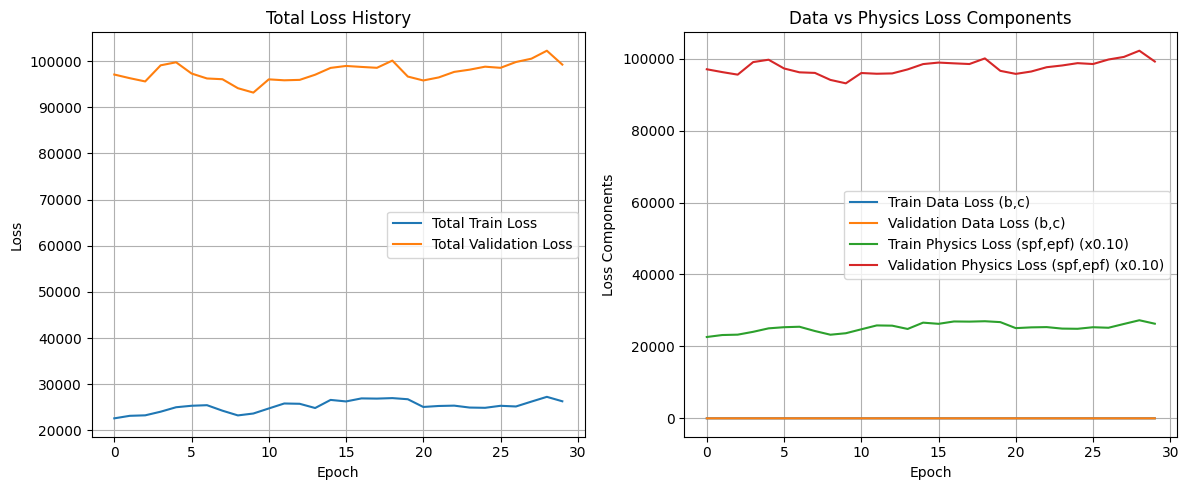

In [10]:
# Cell 9: 학습 루프 (Training Loop) - 하이브리드 손실 함수용으로 수정됨

if len(df) > 0 and 'train_loader' in locals() and 'val_loader' in locals(): # 데이터 로더 존재 확인
    # Hyperparameters
    learning_rate = 0.001
    epochs = 200
    patience = 20

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Early stopping parameters
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Lists to store loss history
    train_loss_history = []
    val_loss_history = []
    train_data_loss_hist = [] # data_loss_bc 저장
    train_phys_loss_hist = [] # physics_loss_spf_epf 저장
    val_data_loss_hist = []   # val_data_loss_bc 저장
    val_phys_loss_hist = []   # val_physics_loss_spf_epf 저장

    print(f"\n--- 학습 시작 (하이브리드 손실) ---")
    print(f"Epochs: {epochs}, LR: {learning_rate}, Lambda_Physics (spf, epf): {lambda_physics_value}, Patience: {patience}")

    for epoch in range(epochs):
        model.train()
        train_epoch_loss = 0.0
        train_epoch_data_loss_bc = 0.0
        train_epoch_phys_loss_spf_epf = 0.0

        # --- E, TS, HB 언패킹하도록 업데이트된 루프 ---
        for batch_X, batch_y_scaled, batch_E, batch_TS, batch_HB in train_loader:
            batch_X = batch_X.to(device)
            batch_y_scaled = batch_y_scaled.to(device)
            batch_E = batch_E.to(device)
            batch_TS = batch_TS.to(device) # TS 전달
            batch_HB = batch_HB.to(device) # HB 전달

            outputs_scaled = model(batch_X)

            # --- 새로운 하이브리드 손실 함수 호출 ---
            loss, data_loss_bc, phys_loss_spf_epf = pinn_hybrid_loss(
                outputs_scaled, batch_y_scaled, batch_E, batch_TS, batch_HB, 
                scaler_y, lambda_physics=lambda_physics_value, device=device
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_epoch_loss += loss.item()
            train_epoch_data_loss_bc += data_loss_bc.item()
            train_epoch_phys_loss_spf_epf += phys_loss_spf_epf.item() if not torch.isnan(phys_loss_spf_epf) else 0.0

        # 에포크 평균 손실 계산
        avg_train_loss = train_epoch_loss / len(train_loader)
        avg_train_data_loss_bc = train_epoch_data_loss_bc / len(train_loader)
        avg_train_phys_loss_spf_epf = train_epoch_phys_loss_spf_epf / len(train_loader)
        train_loss_history.append(avg_train_loss)
        train_data_loss_hist.append(avg_train_data_loss_bc) # b,c에 대한 데이터 손실 저장
        train_phys_loss_hist.append(avg_train_phys_loss_spf_epf) # spf,epf에 대한 물리 손실 저장

        # 검증 단계
        model.eval()
        val_epoch_loss = 0.0
        val_epoch_data_loss_bc = 0.0
        val_epoch_phys_loss_spf_epf = 0.0
        with torch.no_grad():
            # --- E, TS, HB 언패킹하도록 업데이트된 루프 ---
            for batch_X_val, batch_y_val_scaled, batch_E_val, batch_TS_val, batch_HB_val in val_loader:
                batch_X_val = batch_X_val.to(device)
                batch_y_val_scaled = batch_y_val_scaled.to(device)
                batch_E_val = batch_E_val.to(device)
                batch_TS_val = batch_TS_val.to(device) # TS 전달
                batch_HB_val = batch_HB_val.to(device) # HB 전달

                outputs_val_scaled = model(batch_X_val)
                # --- 새로운 하이브리드 손실 함수 호출 ---
                val_loss, val_data_loss_bc, val_phys_loss_spf_epf = pinn_hybrid_loss(
                     outputs_val_scaled, batch_y_val_scaled, batch_E_val, batch_TS_val, batch_HB_val,
                     scaler_y, lambda_physics=lambda_physics_value, device=device
                )
                val_epoch_loss += val_loss.item()
                val_epoch_data_loss_bc += val_data_loss_bc.item()
                val_epoch_phys_loss_spf_epf += val_phys_loss_spf_epf.item() if not torch.isnan(val_phys_loss_spf_epf) else 0.0

        avg_val_loss = val_epoch_loss / len(val_loader)
        avg_val_data_loss_bc = val_epoch_data_loss_bc / len(val_loader)
        avg_val_phys_loss_spf_epf = val_epoch_phys_loss_spf_epf / len(val_loader)
        val_loss_history.append(avg_val_loss)
        val_data_loss_hist.append(avg_val_data_loss_bc) # b,c에 대한 데이터 손실 저장
        val_phys_loss_hist.append(avg_val_phys_loss_spf_epf) # spf,epf에 대한 물리 손실 저장

        # --- 출력 레이블 업데이트 ---
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f} (Data_bc: {avg_train_data_loss_bc:.4f}, Phys_spf_epf: {avg_train_phys_loss_spf_epf:.4f}), "
              f"Val Loss: {avg_val_loss:.4f} (Data_bc: {avg_val_data_loss_bc:.4f}, Phys_spf_epf: {avg_val_phys_loss_spf_epf:.4f})")

        # 조기 종료 확인 (총 검증 손실 사용)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_fatigue_pinn_model.pth')
            print(f"  검증 손실이 개선되었습니다. 최고 모델을 저장했습니다.")
        else:
            epochs_no_improve += 1
            print(f"  검증 손실이 {epochs_no_improve}번째 에포크 동안 개선되지 않았습니다.")

        if epochs_no_improve >= patience:
            print(f"\n{epoch+1}번째 에포크 후 조기 종료가 트리거되었습니다.")
            break

    print("\n--- 학습 완료 ---")

    # 손실 기록 그래프 (레이블 조정)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Total Train Loss')
    plt.plot(val_loss_history, label='Total Validation Loss')
    plt.title('Total Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(train_data_loss_hist, label='Train Data Loss (b,c)')
    plt.plot(val_data_loss_hist, label='Validation Data Loss (b,c)')
    plt.plot(np.array(train_phys_loss_hist) * lambda_physics_value, label=f'Train Physics Loss (spf,epf) (x{lambda_physics_value:.2f})')
    plt.plot(np.array(val_phys_loss_hist) * lambda_physics_value, label=f'Validation Physics Loss (spf,epf) (x{lambda_physics_value:.2f})')
    plt.title('Data vs Physics Loss Components')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Components')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("\n데이터를 사용할 수 없어 학습 루프를 건너뜁니다.")


--- 테스트 세트 평가 중 ---

테스트 세트 성능 (원래 스케일):
  spf_MPa:
    MSE: 340442.7500
    R2 Score: -0.0606
  b:
    MSE: 0.0005
    R2 Score: 0.3097
  epf:
    MSE: 2.1254
    R2 Score: 0.0247
  c:
    MSE: 0.0103
    R2 Score: 0.4607

예측값 vs. 실제값 그래프 생성 중...


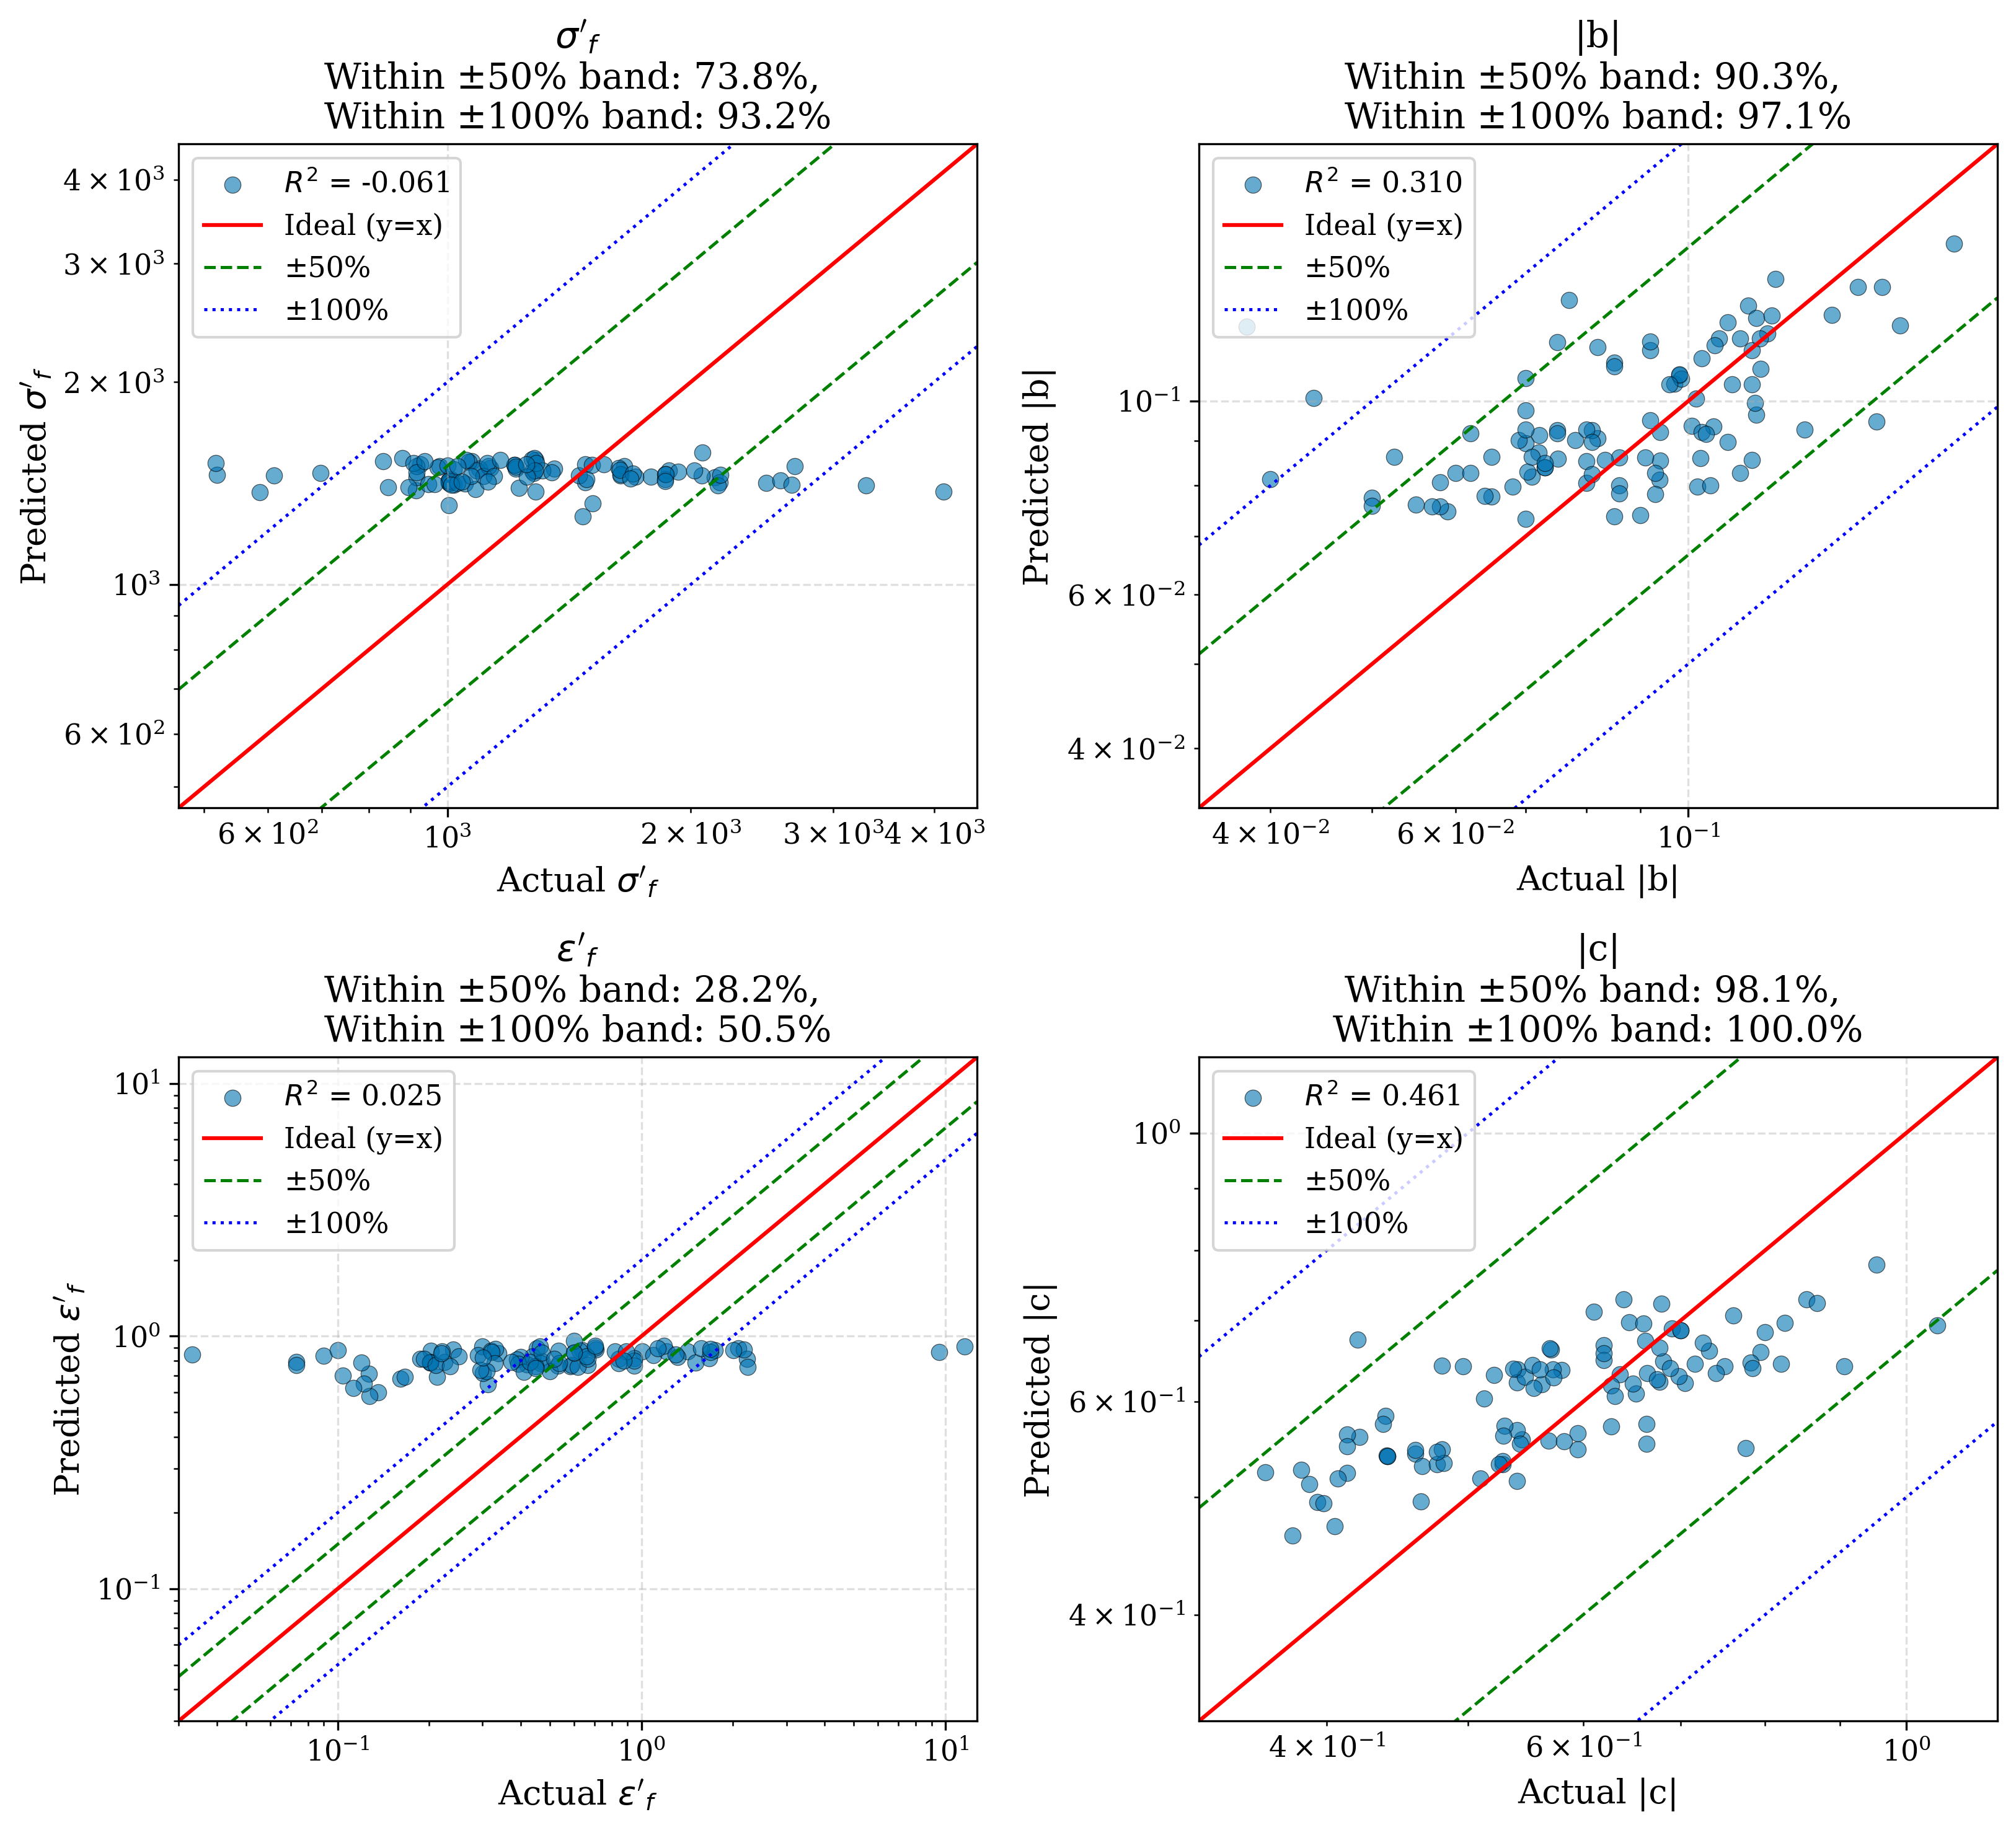

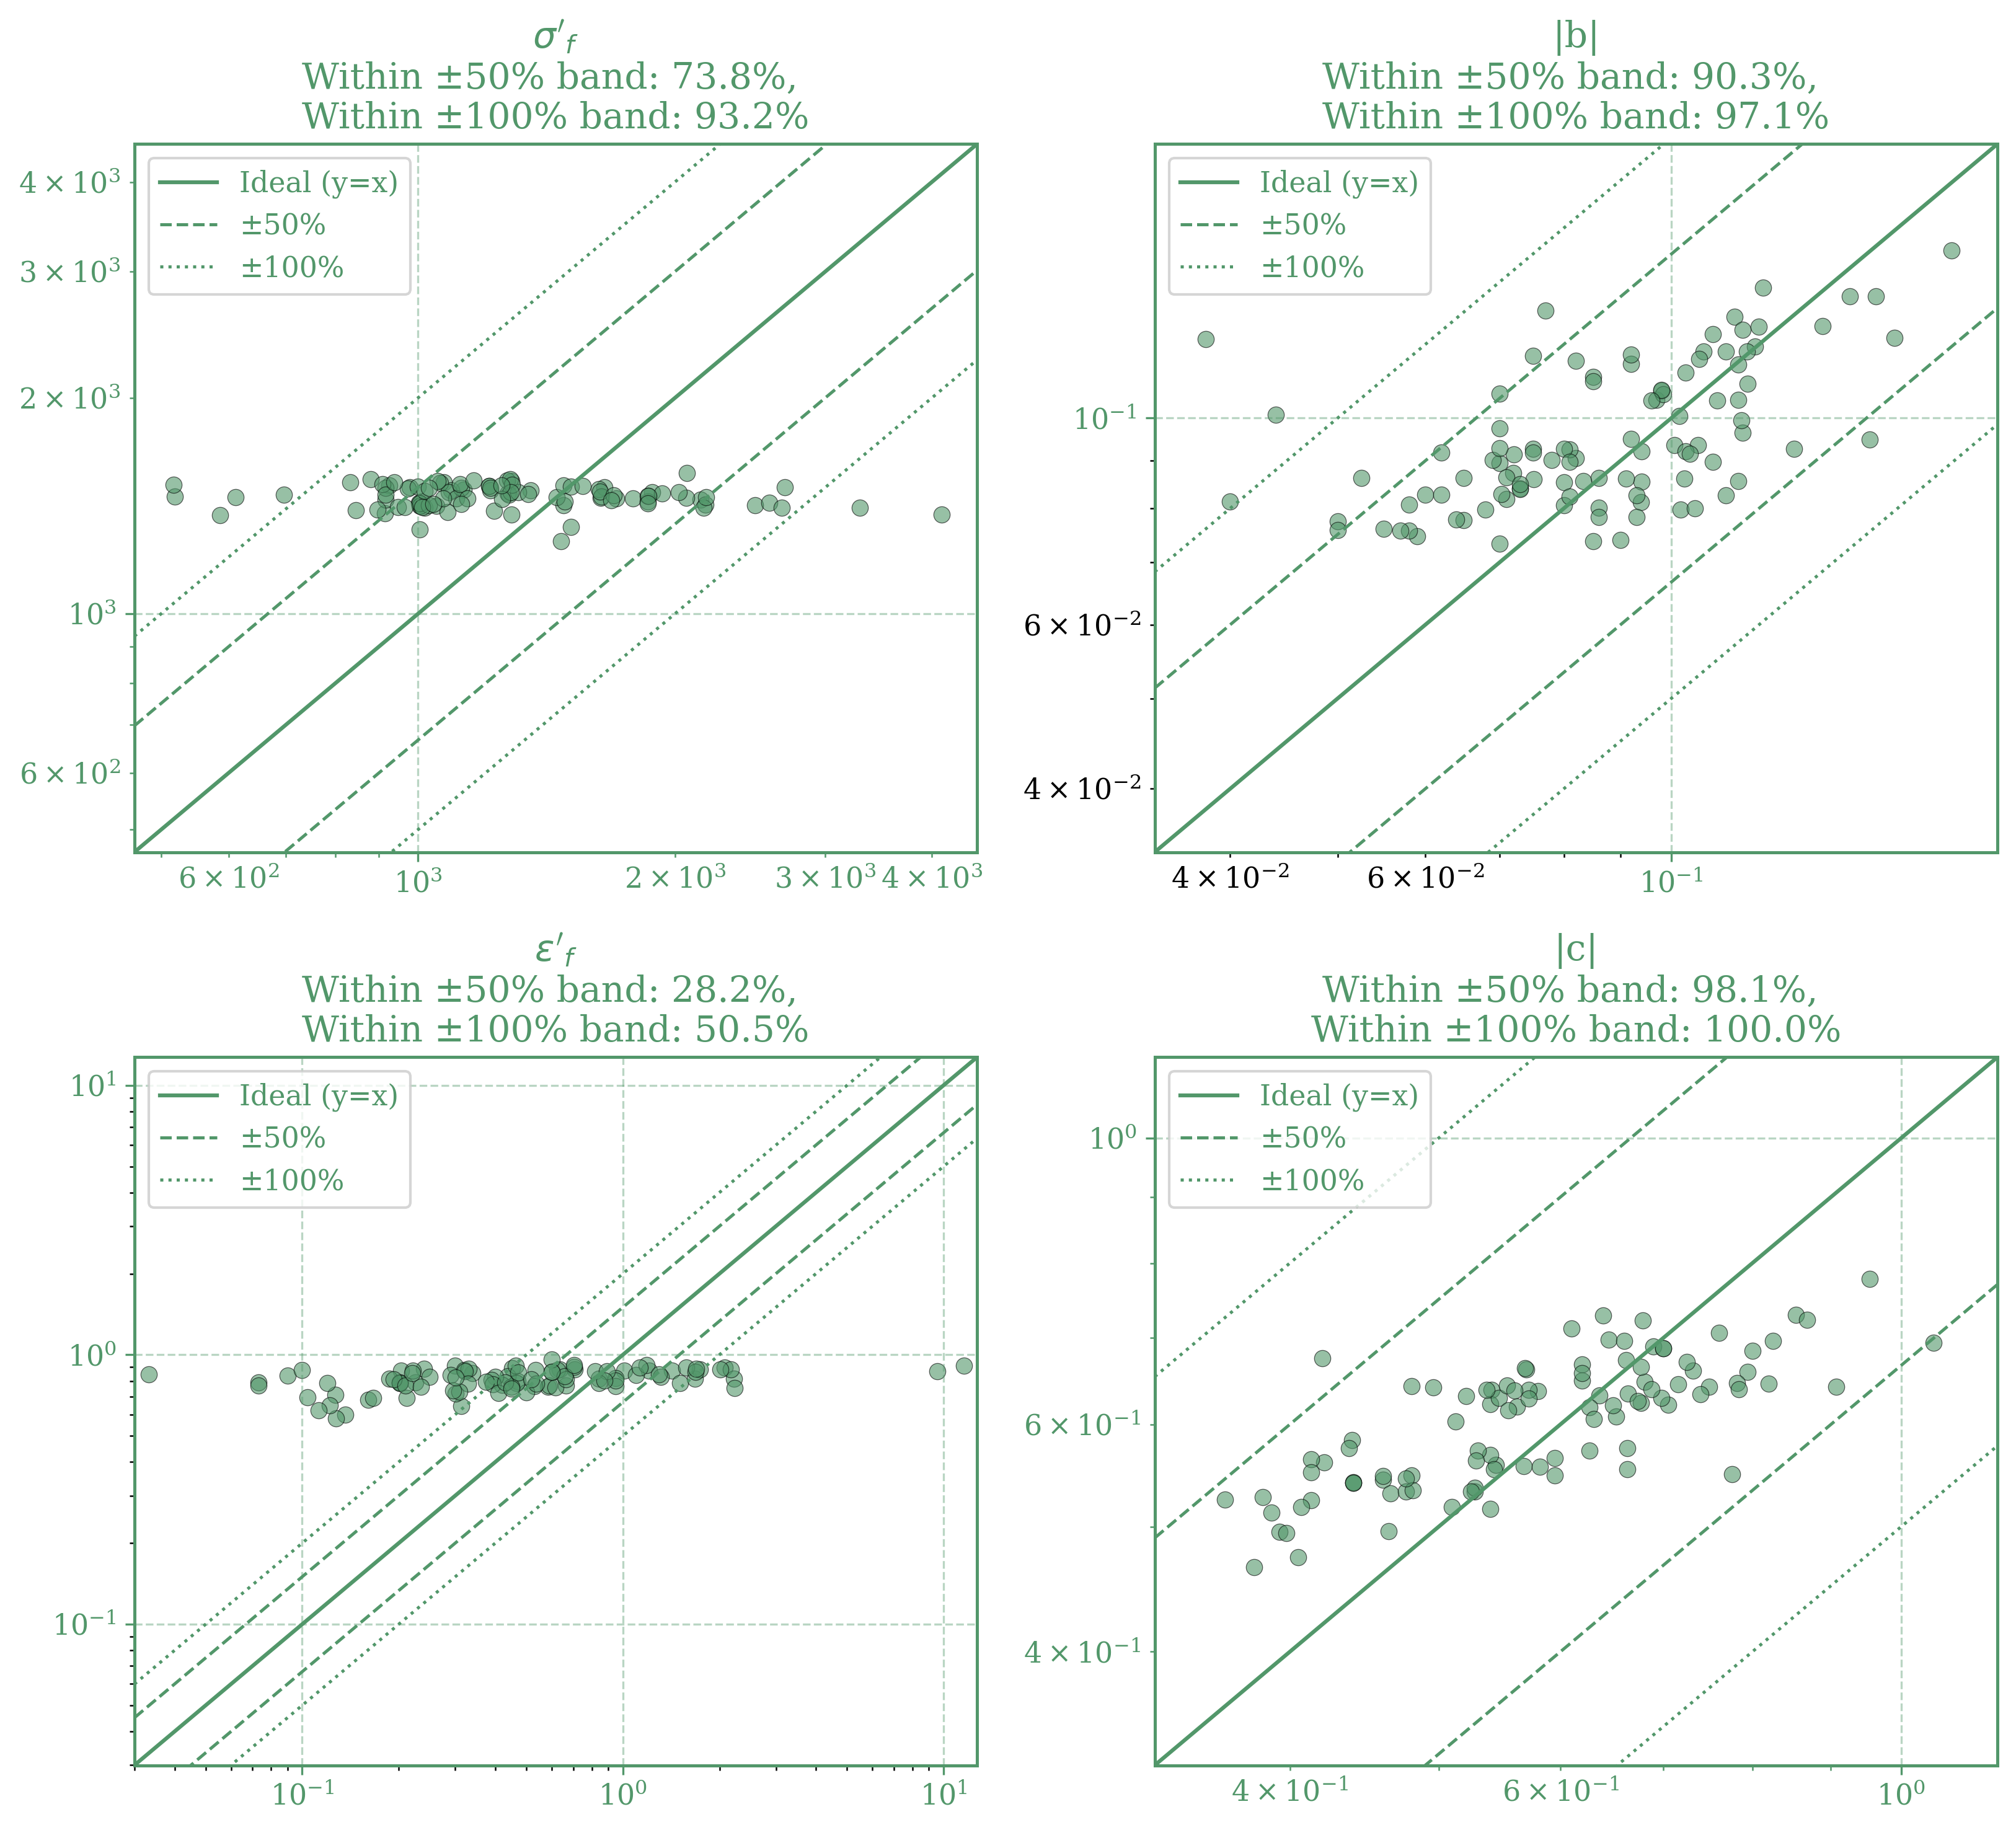

In [11]:
# Cell 10: Evaluation - 언패킹 오류 수정

# 저장된 최적 모델 로드
try: # 파일 로딩 시 오류 처리 추가
    model.load_state_dict(torch.load('best_fatigue_pinn_model.pth', map_location=device))
    model.eval() # 평가 모드로 설정
except FileNotFoundError:
    print("Error: 'best_fatigue_pinn_model.pth' not found. Please train the model first.")
    # 모델 로딩 실패 시 이후 코드 실행 방지
    raise # 또는 exit() 등

all_preds_scaled = []
all_targets_scaled = []
all_targets_orig = []

print("\n--- 테스트 세트 평가 중 ---")
# test_loader가 정의되어 있는지 확인 (Cell 6 실행 여부)
if 'test_loader' not in locals():
    print("Error: test_loader is not defined. Please run Cell 6 first.")
else:
    with torch.no_grad():
        # --- for 루프 언패킹 수정 ---
        # test_loader에서 반환하는 6개의 요소 모두 받기
        for batch_X_test, batch_y_test_scaled, batch_E_test, batch_TS_test, batch_HB_test, batch_y_test_orig in test_loader:
            batch_X_test, batch_y_test_scaled = batch_X_test.to(device), batch_y_test_scaled.to(device)
            # batch_E_test, batch_TS_test, batch_HB_test 는 평가 단계에서는 직접 사용하지 않지만 받아야 함
            
            # Predict scaled parameters
            outputs_test_scaled = model(batch_X_test)

            all_preds_scaled.append(outputs_test_scaled.cpu().numpy())
            all_targets_scaled.append(batch_y_test_scaled.cpu().numpy())
            # 원본 스케일 타겟은 이미 loader에서 가져옴
            all_targets_orig.append(batch_y_test_orig.cpu().numpy()) 

    # Concatenate results from all batches
    all_preds_scaled = np.concatenate(all_preds_scaled, axis=0)
    all_targets_scaled = np.concatenate(all_targets_scaled, axis=0)
    all_targets_orig = np.concatenate(all_targets_orig, axis=0)

    # Inverse transform predictions to original scale
    # scaler_y가 정의되어 있는지 확인 (Cell 6 실행 여부)
    if 'scaler_y' not in locals():
        print("Error: scaler_y is not defined. Cannot inverse transform predictions.")
    else:
        all_preds_orig = scaler_y.inverse_transform(all_preds_scaled)

        # Calculate metrics for each parameter in original scale
        metrics = {}
        print("\n테스트 세트 성능 (원래 스케일):")
        # target_cols가 정의되어 있는지 확인 (Cell 3 실행 여부)
        if 'target_cols' not in locals():
            print("Error: target_cols is not defined. Cannot calculate metrics.")
        else:
            for i, param_name in enumerate(target_cols):
                param_pred = all_preds_orig[:, i]
                param_true = all_targets_orig[:, i]

                mse = mean_squared_error(param_true, param_pred)
                r2 = r2_score(param_true, param_pred)
                metrics[param_name] = {'MSE': mse, 'R2': r2}
                print(f"  {param_name}:")
                print(f"    MSE: {mse:.4f}")
                print(f"    R2 Score: {r2:.4f}")

            # Visualize Predictions vs. Actuals
            print("\n예측값 vs. 실제값 그래프 생성 중...")
            
            import matplotlib as mpl
            # 폰트 및 전역 스타일 설정
            mpl.rcParams.update({
                "font.family": "serif",
                "font.size": 12,
                "axes.labelsize": 13,
                "axes.titlesize": 14,
                "legend.fontsize": 11,
                "xtick.labelsize": 11,
                "ytick.labelsize": 11,
                "lines.linewidth": 1.8,
                "axes.grid": True,
                "grid.alpha": 0.3,
                "figure.dpi": 300,  # 고해상도
            })

            # 색상 팔레트 선택 (Color Universal Design safe)
            import seaborn as sns
            palette = sns.color_palette("colorblind")  # or "muted", "Set2", "deep"

            # 2x2 그리드로 변경
            fig, axes = plt.subplots(2, 2, figsize=(11, 10), facecolor='none')  # 배경 투명하게 설정
            axes = axes.flatten()  # 2D 배열을 1D로 변환하여 쉽게 접근

            for i, param_name in enumerate(target_cols):
                param_pred = all_preds_orig[:, i]
                param_true = all_targets_orig[:, i]
                
                # b와 c 파라미터에 대해 절대값 사용
                if param_name == 'b' or param_name == 'c':
                    param_pred = np.abs(param_pred)
                    param_true = np.abs(param_true)
                
                # 오차 허용 밴드 계산 (예측값이 실제값의 ±50% 또는 ±100% 범위 내에 있는지)
                ratio = param_pred / param_true
                inside_1p5 = np.logical_and(ratio >= 1/1.5, ratio <= 1.5).mean() * 100  # ±50% 오차 범위 내 비율
                inside_2x = np.logical_and(ratio >= 0.5, ratio <= 2.0).mean() * 100     # ±100% 오차 범위 내 비율

                min_val = min(param_pred.min(), param_true.min()) * 0.9
                max_val = max(param_pred.max(), param_true.max()) * 1.1
                
                # 0이나 음수 값이 있을 경우 로그 스케일에 적합한 최소값 설정
                if min_val <= 0:
                    min_val = 1e-6  # 작은 양수값으로 설정
                
                line_vals = np.linspace(min_val, max_val, 100)

                # 산점도
                axes[i].scatter(param_true, param_pred, alpha=0.6, s=40, color=palette[0], edgecolor='k', linewidth=0.3, label=f'$R^2$ = {metrics[param_name]["R2"]:.3f}')

                # 기준선 (y=x) 및 오차 허용 밴드
                axes[i].plot(line_vals, line_vals, 'r-', linewidth=1.5, label='Ideal (y=x)')
                
                # 1.5x error bands (±50% error)
                axes[i].plot(line_vals, line_vals * 1.5, 'g--', linewidth=1.2, label='±50%')
                axes[i].plot(line_vals, line_vals / 1.5, 'g--', linewidth=1.2)
                
                # 2x error bands (±100% error)
                axes[i].plot(line_vals, line_vals * 2.0, 'b:', linewidth=1.2, label='±100%')
                axes[i].plot(line_vals, line_vals * 0.5, 'b:', linewidth=1.2)

                # 로그 스케일 설정 (multiplicative factor가 additive offset으로 보임)
                axes[i].set_xscale('log')
                axes[i].set_yscale('log')

                # Labels and title
                if param_name == 'b' or param_name == 'c':
                    axes[i].set_xlabel(f'Actual |{param_name}|')
                    axes[i].set_ylabel(f'Predicted |{param_name}|')
                    axes[i].set_title(f'|{param_name}|\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%')
                elif param_name == 'spf_MPa':
                    axes[i].set_xlabel(f'Actual $\\sigma\'_f$')
                    axes[i].set_ylabel(f'Predicted $\\sigma\'_f$')
                    axes[i].set_title(f'$\\sigma\'_f$\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%')
                elif param_name == 'epf':
                    axes[i].set_xlabel(f'Actual $\\varepsilon\'_f$')
                    axes[i].set_ylabel(f'Predicted $\\varepsilon\'_f$')
                    axes[i].set_title(f'$\\varepsilon\'_f$\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%')
                else:
                    axes[i].set_xlabel(f'Actual {param_name}')
                    axes[i].set_ylabel(f'Predicted {param_name}')
                    axes[i].set_title(f'{param_name}\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%')
                
                axes[i].set_xlim(min_val, max_val)
                axes[i].set_ylim(min_val, max_val)
                axes[i].legend(frameon=True, loc='upper left')
                axes[i].grid(True, linestyle='--', alpha=0.4)
                axes[i].set_facecolor('none')  # 각 서브플롯 배경 투명하게 설정

            plt.tight_layout()
            plt.savefig("FatifueParameters_prediction_actual.pdf", bbox_inches='tight', transparent=True)  # 투명 배경으로 PDF 저장

            # 두 번째 그래프 - 지정된 색상(R82 G151 B106)으로 저장
            custom_color = (82/255, 151/255, 106/255)  # RGB 값을 0-1 범위로 변환

            # 새로운 그림 생성
            fig2, axes2 = plt.subplots(2, 2, figsize=(11, 10), facecolor='none')
            axes2 = axes2.flatten()

            for i, param_name in enumerate(target_cols):
                param_pred = all_preds_orig[:, i]
                param_true = all_targets_orig[:, i]
                
                if param_name == 'b' or param_name == 'c':
                    param_pred = np.abs(param_pred)
                    param_true = np.abs(param_true)
                
                ratio = param_pred / param_true
                inside_1p5 = np.logical_and(ratio >= 1/1.5, ratio <= 1.5).mean() * 100
                inside_2x = np.logical_and(ratio >= 0.5, ratio <= 2.0).mean() * 100

                min_val = min(param_pred.min(), param_true.min()) * 0.9
                max_val = max(param_pred.max(), param_true.max()) * 1.1
                
                if min_val <= 0:
                    min_val = 1e-6
                
                line_vals = np.linspace(min_val, max_val, 100)

                # 산점도 추가 - 커스텀 색상 그래프에도 산점도 추가
                axes2[i].scatter(param_true, param_pred, alpha=0.6, s=40, color=custom_color, edgecolor='k', linewidth=0.3) #label=f'$R^2$ = {metrics[param_name]["R2"]:.3f}'

                # 모든 선을 지정된 색상으로 설정
                axes2[i].plot(line_vals, line_vals, '-', color=custom_color, linewidth=1.5, label='Ideal (y=x)')
                axes2[i].plot(line_vals, line_vals * 1.5, '--', color=custom_color, linewidth=1.2, label='±50%')
                axes2[i].plot(line_vals, line_vals / 1.5, '--', color=custom_color, linewidth=1.2)
                axes2[i].plot(line_vals, line_vals * 2.0, ':', color=custom_color, linewidth=1.2, label='±100%')
                axes2[i].plot(line_vals, line_vals * 0.5, ':', color=custom_color, linewidth=1.2)

                axes2[i].set_xscale('log')
                axes2[i].set_yscale('log')

                if param_name == 'b' or param_name == 'c':
                    axes2[i].set_title(f'|{param_name}|\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%', color=custom_color)
                elif param_name == 'spf_MPa':
                    axes2[i].set_title(f'$\\sigma\'_f$\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%', color=custom_color)
                elif param_name == 'epf':
                    axes2[i].set_title(f'$\\varepsilon\'_f$\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%', color=custom_color)
                else:
                    axes2[i].set_title(f'{param_name}\nWithin ±50% band: {inside_1p5:.1f}%, \nWithin ±100% band: {inside_2x:.1f}%', color=custom_color)
                
                axes2[i].set_xlim(min_val, max_val)
                axes2[i].set_ylim(min_val, max_val)
                axes2[i].legend(frameon=True, loc='upper left', labelcolor=custom_color)
                axes2[i].grid(True, linestyle='--', alpha=0.4, color=custom_color)
                axes2[i].set_facecolor('none')
                
                # 테두리 색상을 custom_color로 변경
                for spine in axes2[i].spines.values():
                    spine.set_color(custom_color)
                    spine.set_linewidth(1.2)
                
                # 축 눈금 및 레이블 색상 변경
                axes2[i].tick_params(axis='both', colors=custom_color)
                
                # 로그 스케일 눈금 값들의 색상 변경 - 모든 그래프에 적용
                for label in axes2[i].get_xticklabels():
                    label.set_color(custom_color)
                for label in axes2[i].get_yticklabels():
                    label.set_color(custom_color)
                
                # 로그 스케일 눈금 색상 변경 추가 확인 (sigma'f와 c 그래프용)
                if param_name == 'spf_MPa' or param_name == 'c':
                    # 메이저 및 마이너 눈금 모두 색상 변경
                    axes2[i].tick_params(axis='x', which='both', colors=custom_color)
                    axes2[i].tick_params(axis='y', which='both', colors=custom_color)
                    
                    # 모든 눈금 레이블 색상 명시적 설정
                    for label in axes2[i].xaxis.get_ticklabels(which='both'):
                        label.set_color(custom_color)
                    for label in axes2[i].yaxis.get_ticklabels(which='both'):
                        label.set_color(custom_color)

            plt.tight_layout()
            plt.show()



--- Testing E-N and Gamma-N Curve Generation (Hybrid Output) ---
Example Input:
  E: 221000 MPa
  YS: 579 MPa
  TS: 898 MPa
  HB: 249.0

Final Tensile Parameters (Hybrid):
  spf_MPa: 1283.2500
  b: -0.0818
  epf: 0.4053
  c: -0.6088
  estimation_method_spf_epf: Hardness Method

Final Shear Parameters (Hybrid):
  tauf_MPa: 740.8847
  gammaf: 0.7020
  b0: -0.0818
  c0: -0.6088
  conversion_method: von Mises Criteria


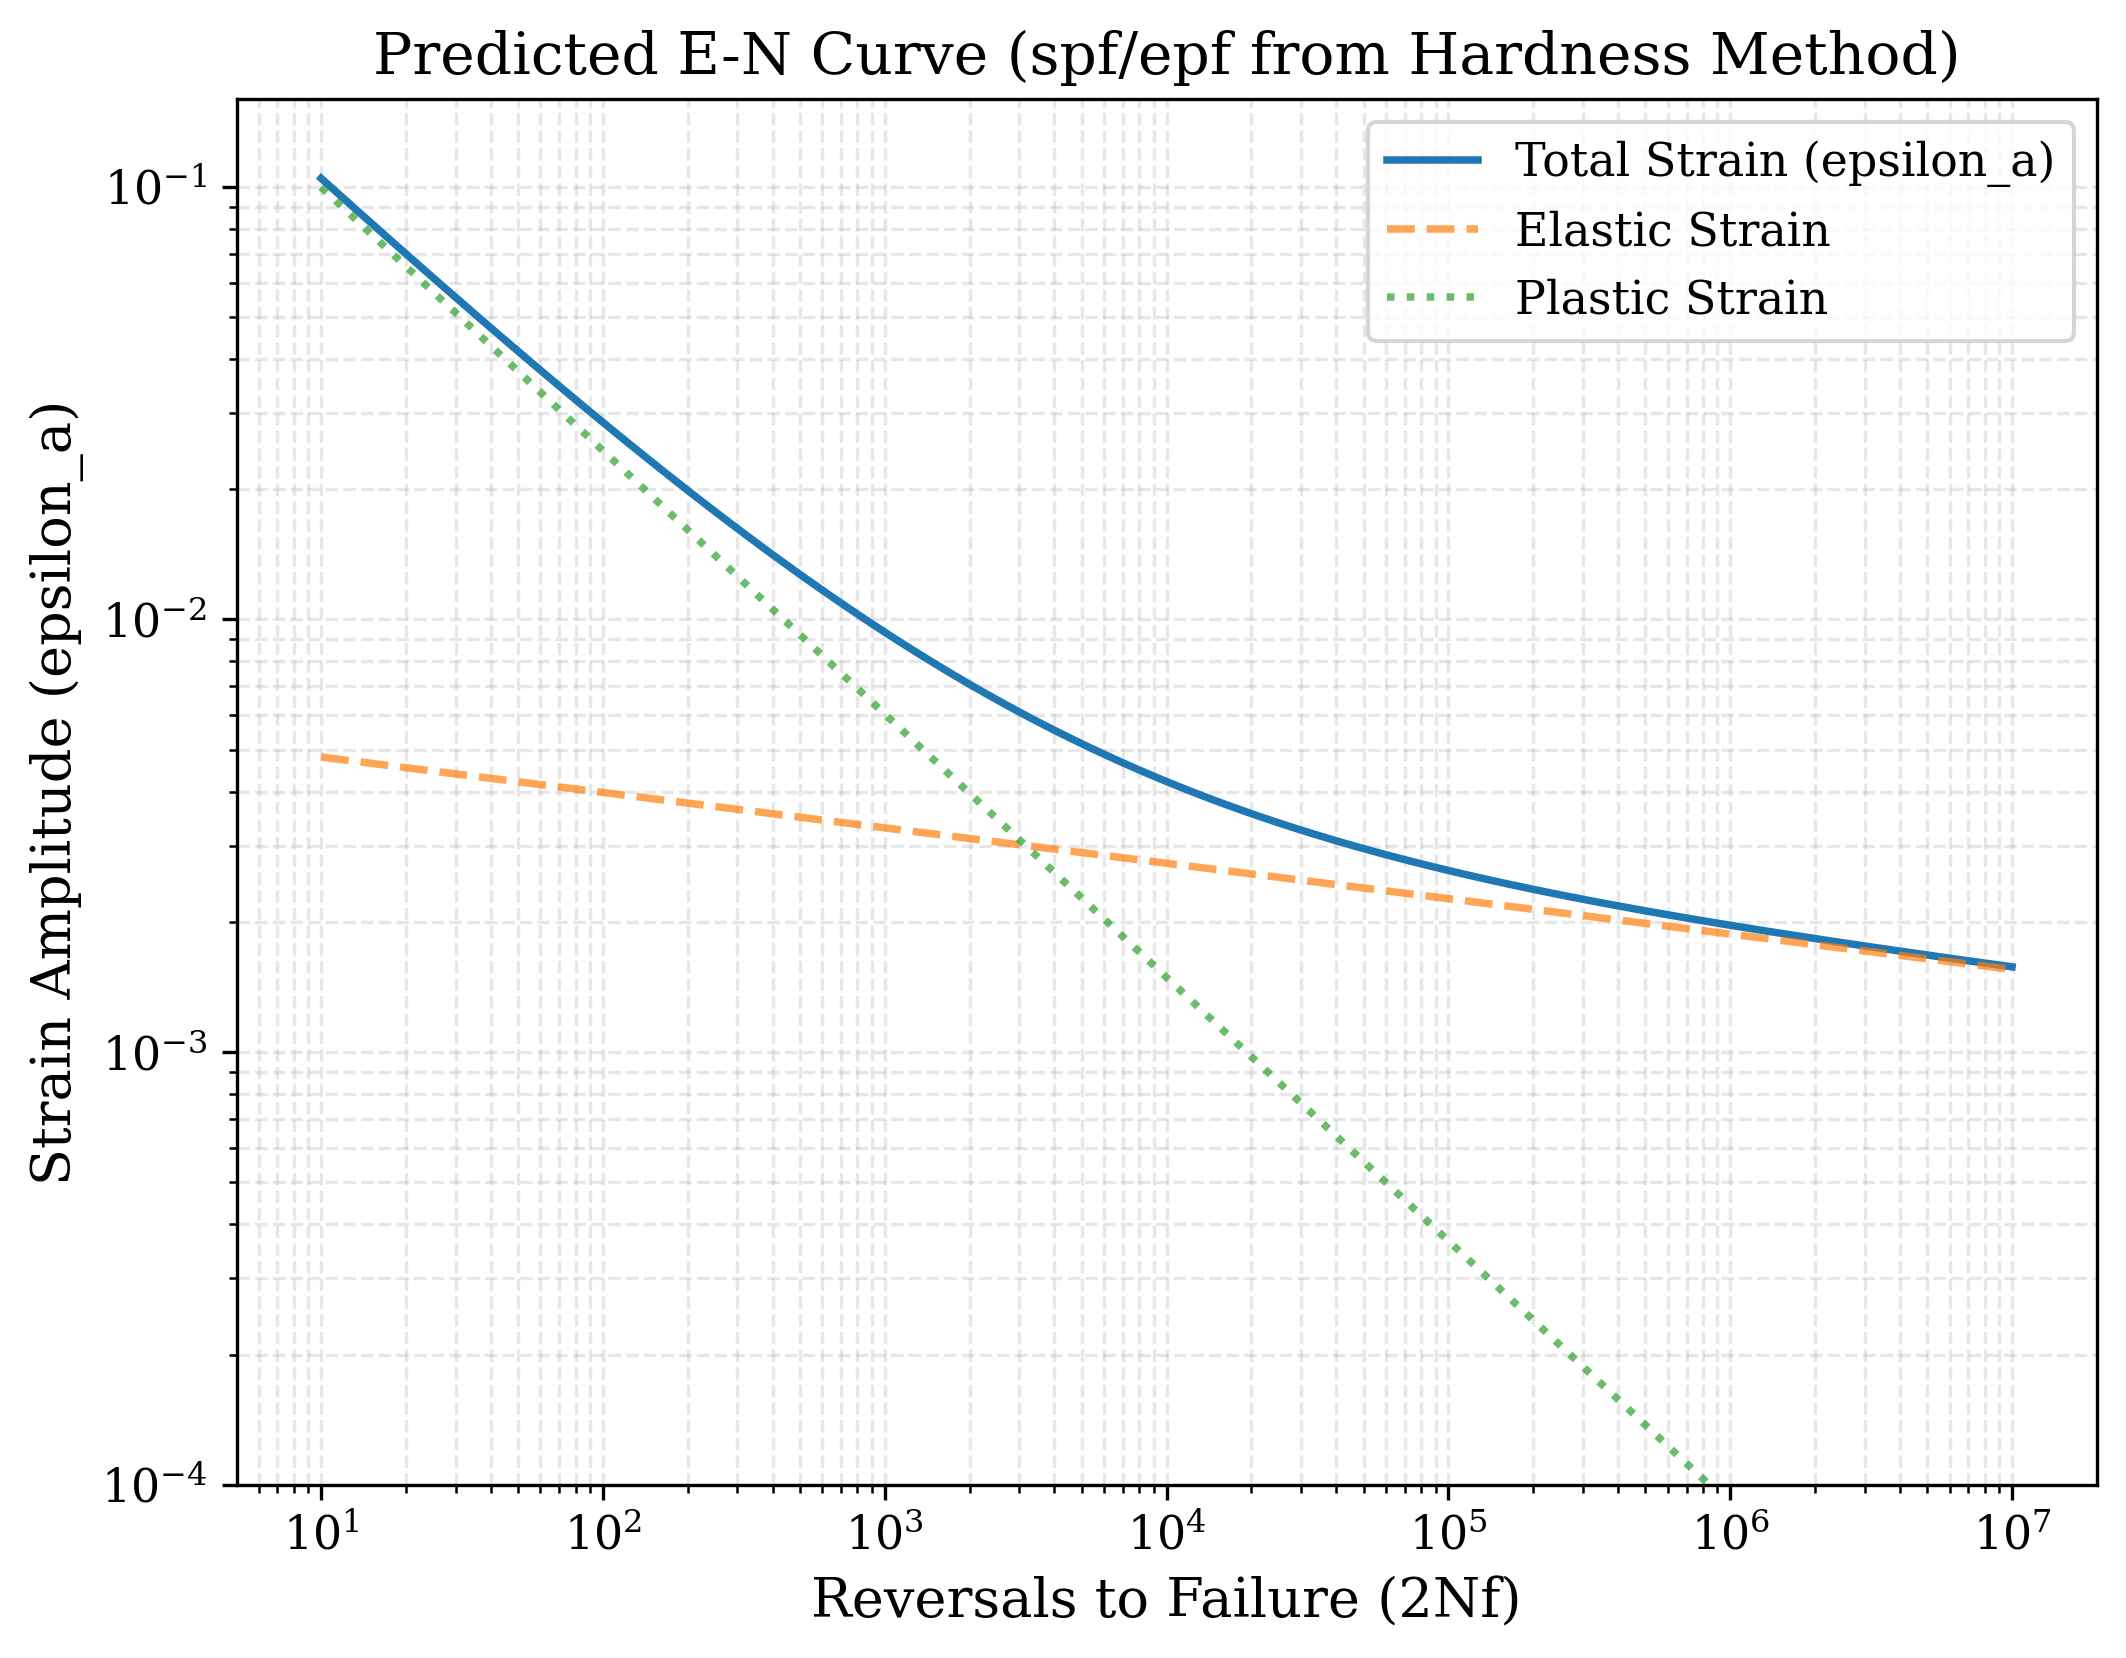

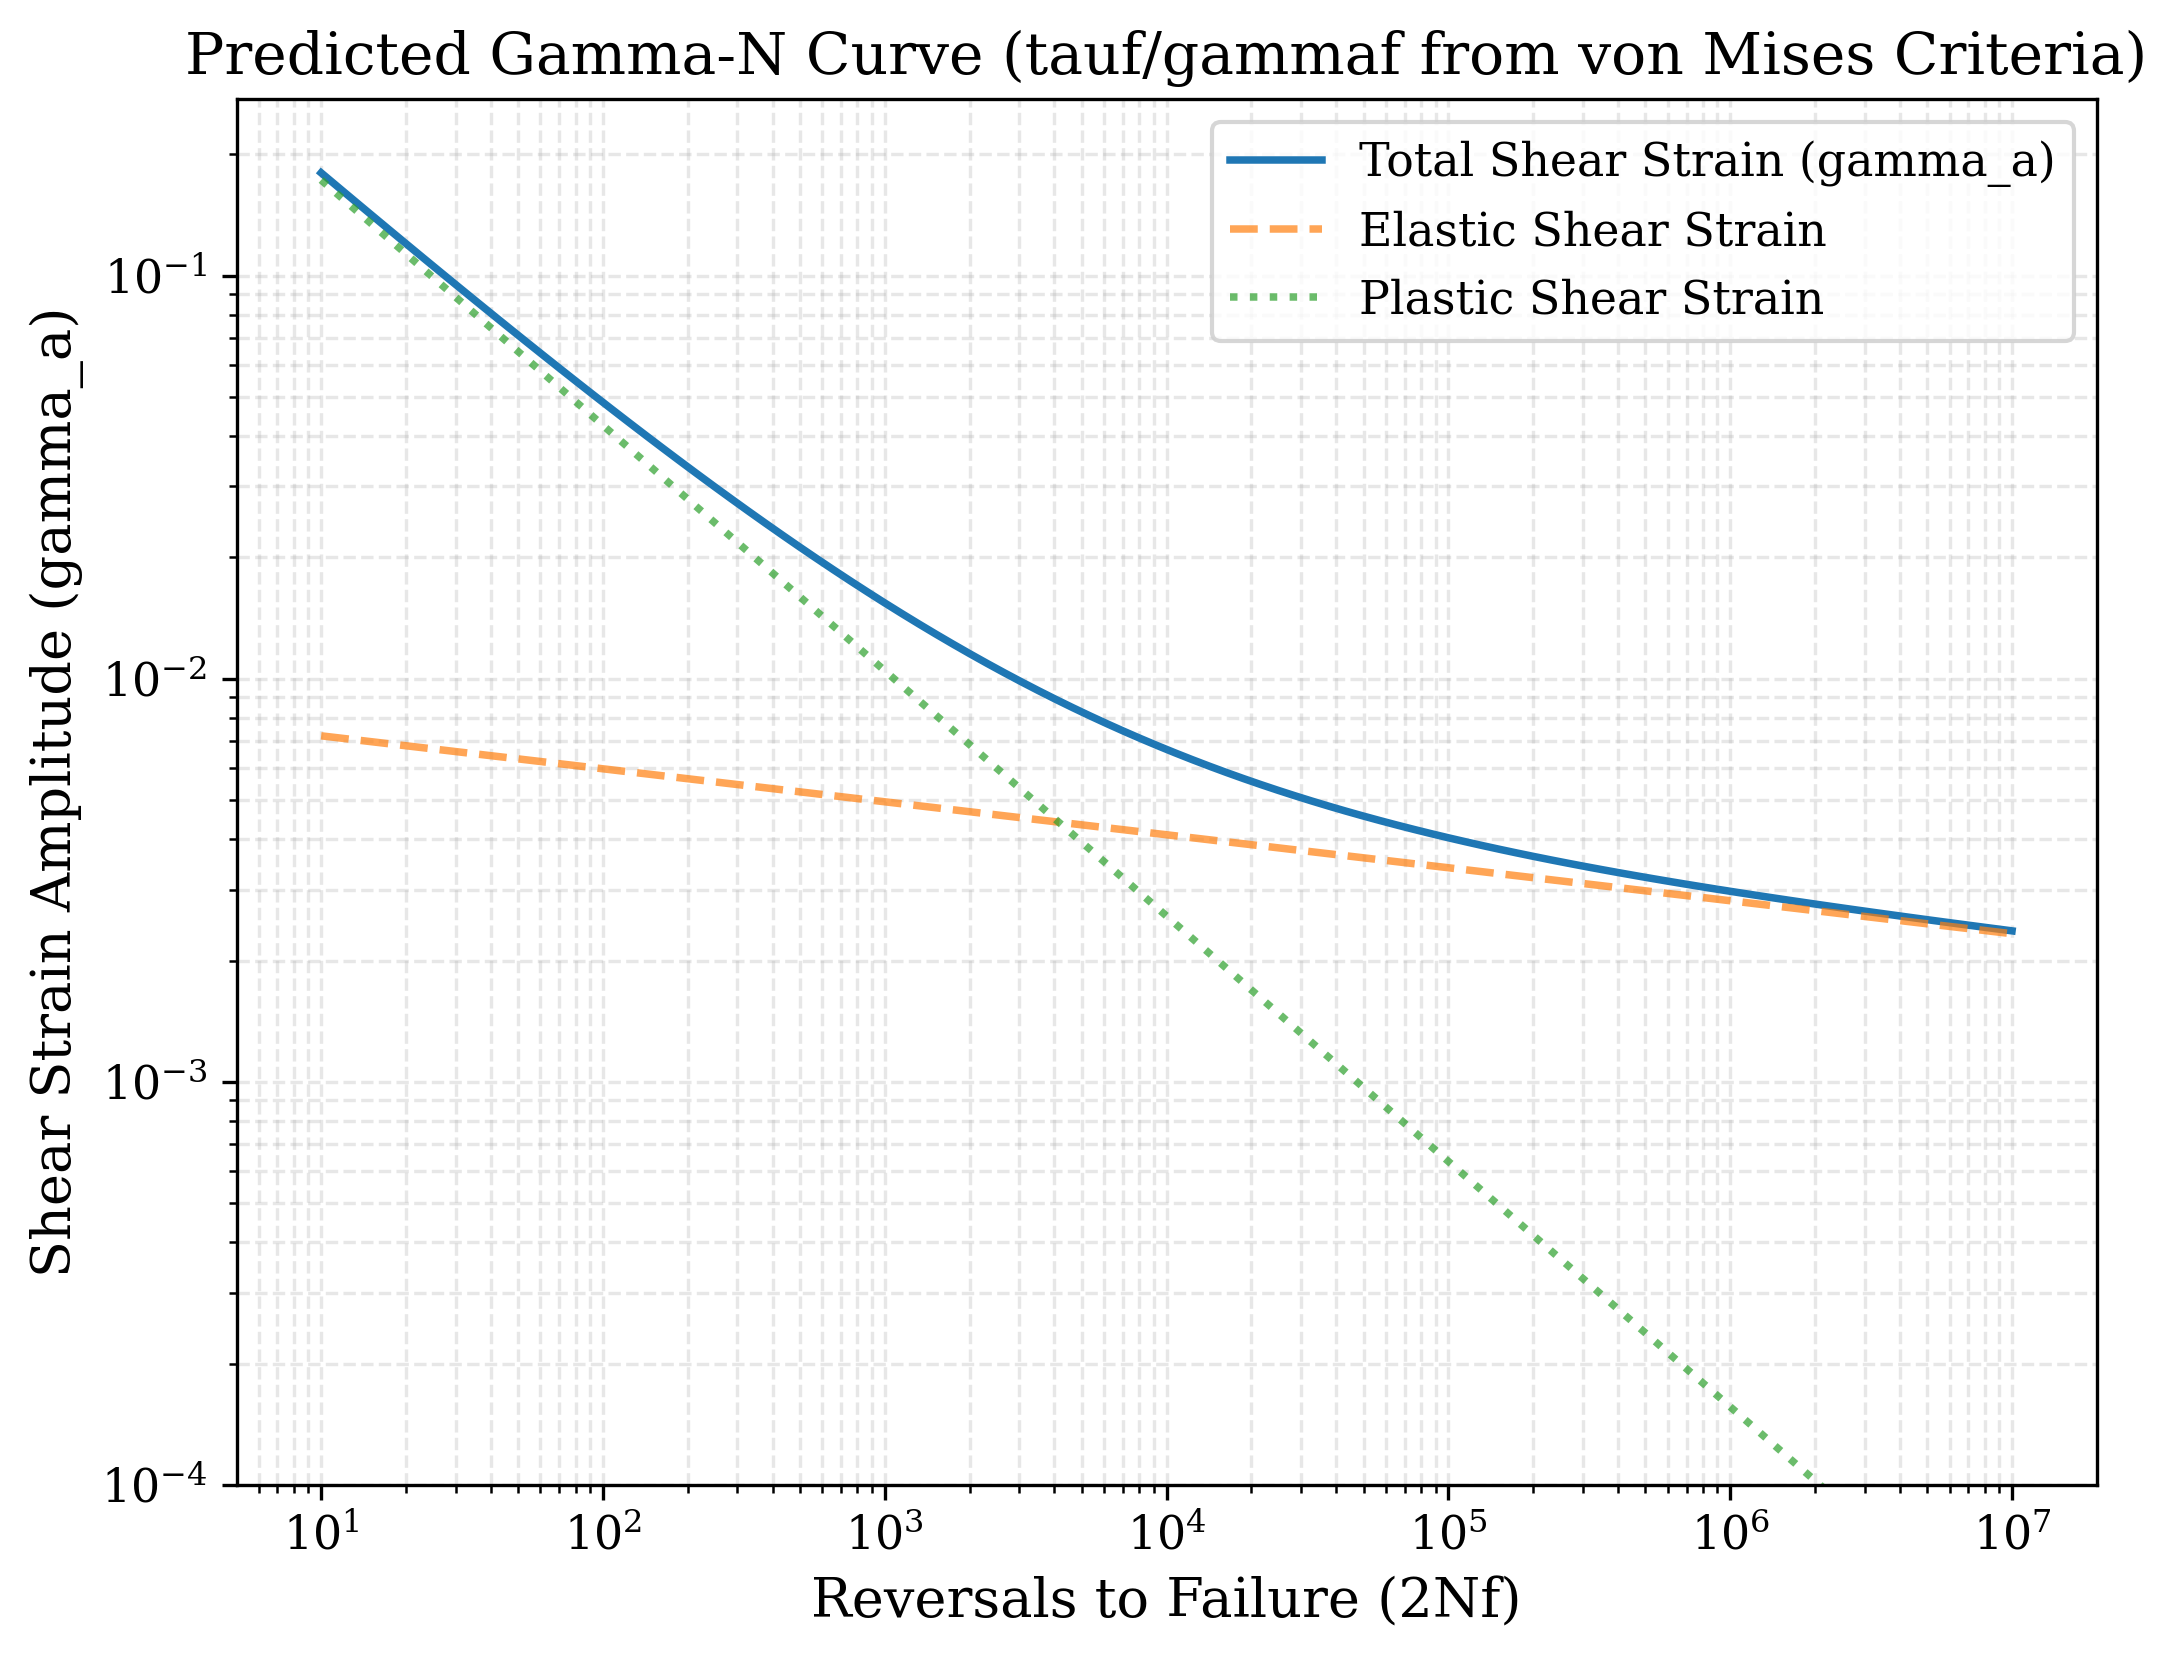

In [12]:
# Cell 11: E-N 및 Gamma-N 곡선 생성 함수 (수정됨 - Hybrid Output)

if len(df) > 0:
    # Assuming empirical method functions (Cell 7.5) are defined

    def predict_fatigue_curves_hybrid(E_val, YS_val, TS_val, HB_val, model, scaler_X, scaler_y, device, nu=0.3):
        """
        Predicts b, c using NN and calculates spf', epf' using physics methods.
        Generates E-N and Gamma-N curve data.

        Args:
            # ... (Args are the same as previous version) ...

        Returns:
            tuple: (final_tensile_params, reversals, strain_amplitude_en, elastic_strain_en, plastic_strain_en,
                    final_shear_params, reversals, strain_amplitude_gn, elastic_shear_strain_gn, plastic_shear_strain_gn)
                   - final_tensile_params (dict): Hybrid parameters (physics spf/epf, NN b/c).
                   - ... (rest of the curve data) ...
                   - final_shear_params (dict): Converted shear parameters (physics tauf/gammaf, NN b0/c0).
        """
        model.eval() 

        # --- 1. Get NN predictions for all 4 params (scaled) ---
        input_features = np.array([[E_val, YS_val, TS_val, HB_val]])
        input_scaled = scaler_X.transform(input_features)
        input_tensor = torch.tensor(input_scaled, dtype=torch.float32).to(device)

        with torch.no_grad():
            predicted_all_params_scaled = model(input_tensor)
        
        # --- 2. Inverse transform NN predictions for b and c ONLY ---
        predicted_all_params_orig_np = scaler_y.inverse_transform(predicted_all_params_scaled.cpu().numpy())
        b_nn = predicted_all_params_orig_np[0, 1] # Index 1 for b
        c_nn = predicted_all_params_orig_np[0, 3] # Index 3 for c
        
        # --- 3. Calculate spf' and epf' using Physics Methods ---
        spf_physics, epf_physics, method_name = get_physics_params(HB_val, TS_val, E_val)
        
        # Handle potential None returns from physics methods
        if spf_physics is None: spf_physics = np.nan
        if epf_physics is None: epf_physics = np.nan
            
        # --- 4. Assemble Final Tensile Parameters (Hybrid) ---
        tensile_params = {
            'spf_MPa': spf_physics, 
            'b': b_nn, 
            'epf': epf_physics, 
            'c': c_nn,
            'estimation_method_spf_epf': method_name # Add method used
        }

        # --- 5. Calculate E-N Curve using final tensile params ---
        reversals = np.logspace(1, 7, num=100) 
        E_val_safe = max(E_val, 1e-6) 
        elastic_strain_en = np.full_like(reversals, np.nan)
        plastic_strain_en = np.full_like(reversals, np.nan)
        strain_amplitude_en = np.full_like(reversals, np.nan)
        
        if not any(np.isnan(val) for key, val in tensile_params.items() if key != 'estimation_method_spf_epf'):
            elastic_strain_en = (tensile_params['spf_MPa'] / E_val_safe) * (reversals ** tensile_params['b'])
            plastic_strain_en = tensile_params['epf'] * (reversals ** tensile_params['c'])
            strain_amplitude_en = elastic_strain_en + plastic_strain_en
        else:
            print("Warning: Could not calculate Tensile curve due to invalid parameters.")

        # --- 6. Convert to Shear Parameters using final tensile params ---
        shear_params = {}
        conversion_method = "Unknown"
        spf_prime = tensile_params['spf_MPa'] # Use physics-based spf'
        b = tensile_params['b']             # Use NN-based b
        epf_prime = tensile_params['epf']   # Use physics-based epf'
        c = tensile_params['c']             # Use NN-based c
        
        # Apply conversion rules (same as before, but using potentially hybrid tensile params)
        if not np.isnan(spf_prime) and not np.isnan(epf_prime): # Check if physics params are valid
            tau_vm = spf_prime / np.sqrt(3)
            gamma_vm = np.sqrt(3) * epf_prime
            tau_mp = spf_prime / (1 + nu)
            gamma_mp = 2 * epf_prime
            
            if TS_val <= 1100:
                tauf_prime, gammaf_prime = tau_vm, gamma_vm
                conversion_method = "von Mises Criteria"
            elif TS_val >= 1696:
                tauf_prime, gammaf_prime = tau_mp, gamma_mp
                conversion_method = "Maximum Principal Criteria"
            else: 
                alpha = (TS_val - 1100) / (1696 - 1100)
                tauf_prime = (1-alpha)*tau_vm + alpha*tau_mp
                gammaf_prime = (1-alpha)*gamma_vm + alpha*gamma_mp
                conversion_method = f"Interpolated (α={alpha:.2f})"
        else:
             tauf_prime, gammaf_prime = np.nan, np.nan # Set shear params to NaN if tensile were NaN
        
        # Use NN-based b, c for b0, c0
        b0 = b_nn
        c0 = c_nn

        shear_params['tauf_MPa'] = tauf_prime
        shear_params['gammaf'] = gammaf_prime
        shear_params['b0'] = b0
        shear_params['c0'] = c0
        shear_params['conversion_method'] = conversion_method

        # --- 7. Calculate Gamma-N Curve using final shear params ---
        G_val = E_val_safe / (2 * (1 + nu))
        elastic_shear_strain_gn = np.full_like(reversals, np.nan)
        plastic_shear_strain_gn = np.full_like(reversals, np.nan)
        strain_amplitude_gn = np.full_like(reversals, np.nan)
        
        if not any(np.isnan(val) for key, val in shear_params.items() if key != 'conversion_method'):
             elastic_shear_strain_gn = (shear_params['tauf_MPa'] / G_val) * (reversals ** shear_params['b0'])
             plastic_shear_strain_gn = shear_params['gammaf'] * (reversals ** shear_params['c0'])
             strain_amplitude_gn = elastic_shear_strain_gn + plastic_shear_strain_gn
        else:
             print("Warning: Could not calculate Shear curve due to invalid parameters.")

        return (tensile_params, reversals, strain_amplitude_en, elastic_strain_en, plastic_strain_en,
                shear_params, reversals, strain_amplitude_gn, elastic_shear_strain_gn, plastic_shear_strain_gn)

    # --- 함수 테스트 (업데이트된 반환값 사용) ---
    print("\n--- Testing E-N and Gamma-N Curve Generation (Hybrid Output) ---")
    try:
        example_input_X = X_test[0] 
        example_E = E_test[0]      
        example_TS = example_input_X[2] 
        example_HB = example_input_X[-1] 

        print(f"Example Input:")
        print(f"  E: {example_E:.0f} MPa")
        print(f"  YS: {example_input_X[1]:.0f} MPa")
        print(f"  TS: {example_TS:.0f} MPa")
        print(f"  HB: {example_HB:.1f}")

        # --- 업데이트된 반환값 받기 ---
        tensile_p, rev_en, strain_en_tot, strain_en_el, strain_en_pl, shear_p, rev_gn, strain_gn_tot, strain_gn_el, strain_gn_pl = predict_fatigue_curves_hybrid(
            example_E, example_input_X[1], example_TS, example_HB,
            model, scaler_X, scaler_y, device, nu=0.3
        )

        print("\nFinal Tensile Parameters (Hybrid):")
        for name, val in tensile_p.items(): print(f"  {name}: {val if isinstance(val, str) else f'{val:.4f}'}")
        print("\nFinal Shear Parameters (Hybrid):")
        for name, val in shear_p.items(): print(f"  {name}: {val if isinstance(val, str) else f'{val:.4f}'}")

        # E-N 곡선 플롯 (구성 요소 포함)
        plt.figure(figsize=(8, 6))
        if not np.isnan(strain_en_tot).all():
             plt.loglog(rev_en, strain_en_tot, '-', label='Total Strain (epsilon_a)')
             plt.loglog(rev_en, strain_en_el, '--', label='Elastic Strain', alpha=0.7)
             plt.loglog(rev_en, strain_en_pl, ':', label='Plastic Strain', alpha=0.7)
             plt.xlabel('Reversals to Failure (2Nf)')
             plt.ylabel('Strain Amplitude (epsilon_a)')
             plt.title(f'Predicted E-N Curve (spf/epf from {tensile_p["estimation_method_spf_epf"]})')
             plt.legend()
             plt.grid(True, which="both", ls="--")
             plt.ylim(bottom=1e-4)
        else:
             plt.text(0.5, 0.5, 'Could not generate Tensile Curve', ha='center', va='center')
             plt.title('Predicted E-N Curve (Calculation Failed)')
        plt.show()

        # Gamma-N 곡선 플롯 (구성 요소 포함)
        plt.figure(figsize=(8, 6))
        if not np.isnan(strain_gn_tot).all():
             plt.loglog(rev_gn, strain_gn_tot, '-', label='Total Shear Strain (gamma_a)')
             plt.loglog(rev_gn, strain_gn_el, '--', label='Elastic Shear Strain', alpha=0.7)
             plt.loglog(rev_gn, strain_gn_pl, ':', label='Plastic Shear Strain', alpha=0.7)
             plt.xlabel('Reversals to Failure (2Nf)')
             plt.ylabel('Shear Strain Amplitude (gamma_a)')
             plt.title(f'Predicted Gamma-N Curve (tauf/gammaf from {shear_p["conversion_method"]})')
             plt.legend()
             plt.grid(True, which="both", ls="--")
             plt.ylim(bottom=1e-4)
        else:
             plt.text(0.5, 0.5, 'Could not generate Shear Curve', ha='center', va='center')
             plt.title('Predicted Gamma-N Curve (Calculation Failed)')
        plt.show()

    except Exception as e:
        print(f"An error occurred during testing: {e}")
else:
     print("\nSkipping curve generation function definition and testing.")
